# Imports

In [2]:
import sys
import os

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import json
from jupyterthemes import jtplot
from tqdm.auto import tqdm
jtplot.style()
%matplotlib inline

c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [88]:
data = pl.read_csv("more_features_filtered_data_9db.csv")

In [89]:
data.head()

shape: (5, 30)
┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬─────────┬───────┐
│ cluster_1_ ┆ cluster_1_ ┆ cluster_1_ ┆ cluster_1_ ┆ … ┆ cluster_4_ ┆ cluster_4_ ┆ file    ┆ label │
│ span       ┆ min_amp    ┆ max_amp    ┆ height_amp ┆   ┆ grad       ┆ std        ┆ ---     ┆ ---   │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ i64     ┆ i64   │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆         ┆       │
╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪═════════╪═══════╡
│ 6.248279   ┆ 15.75      ┆ 23.75      ┆ 8.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 1015896 ┆ 1     │
│ 6.248279   ┆ 8.0        ┆ 11.75      ┆ 3.75       ┆ … ┆ 0.0        ┆ 0.0        ┆ 1025150 ┆ 1     │
│ 6.248279   ┆ 8.0        ┆ 27.25      ┆ 19.25      ┆ … ┆ 0.0        ┆ 0.0        ┆ 1029777 ┆ 1     │
│ 6.161012   ┆ 8.0        ┆ 10.5       ┆ 2.5        ┆ … ┆ 0.0        ┆ 0.0        ┆ 1044434 ┆ 1     │
│ 1.640609   ┆ 8.0        ┆ 21.0       ┆ 13.0       ┆ … ┆ 0.0        ┆ 0.0        ┆ 1054130 ┆ 1     │
└────────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴─────────┴───────┘

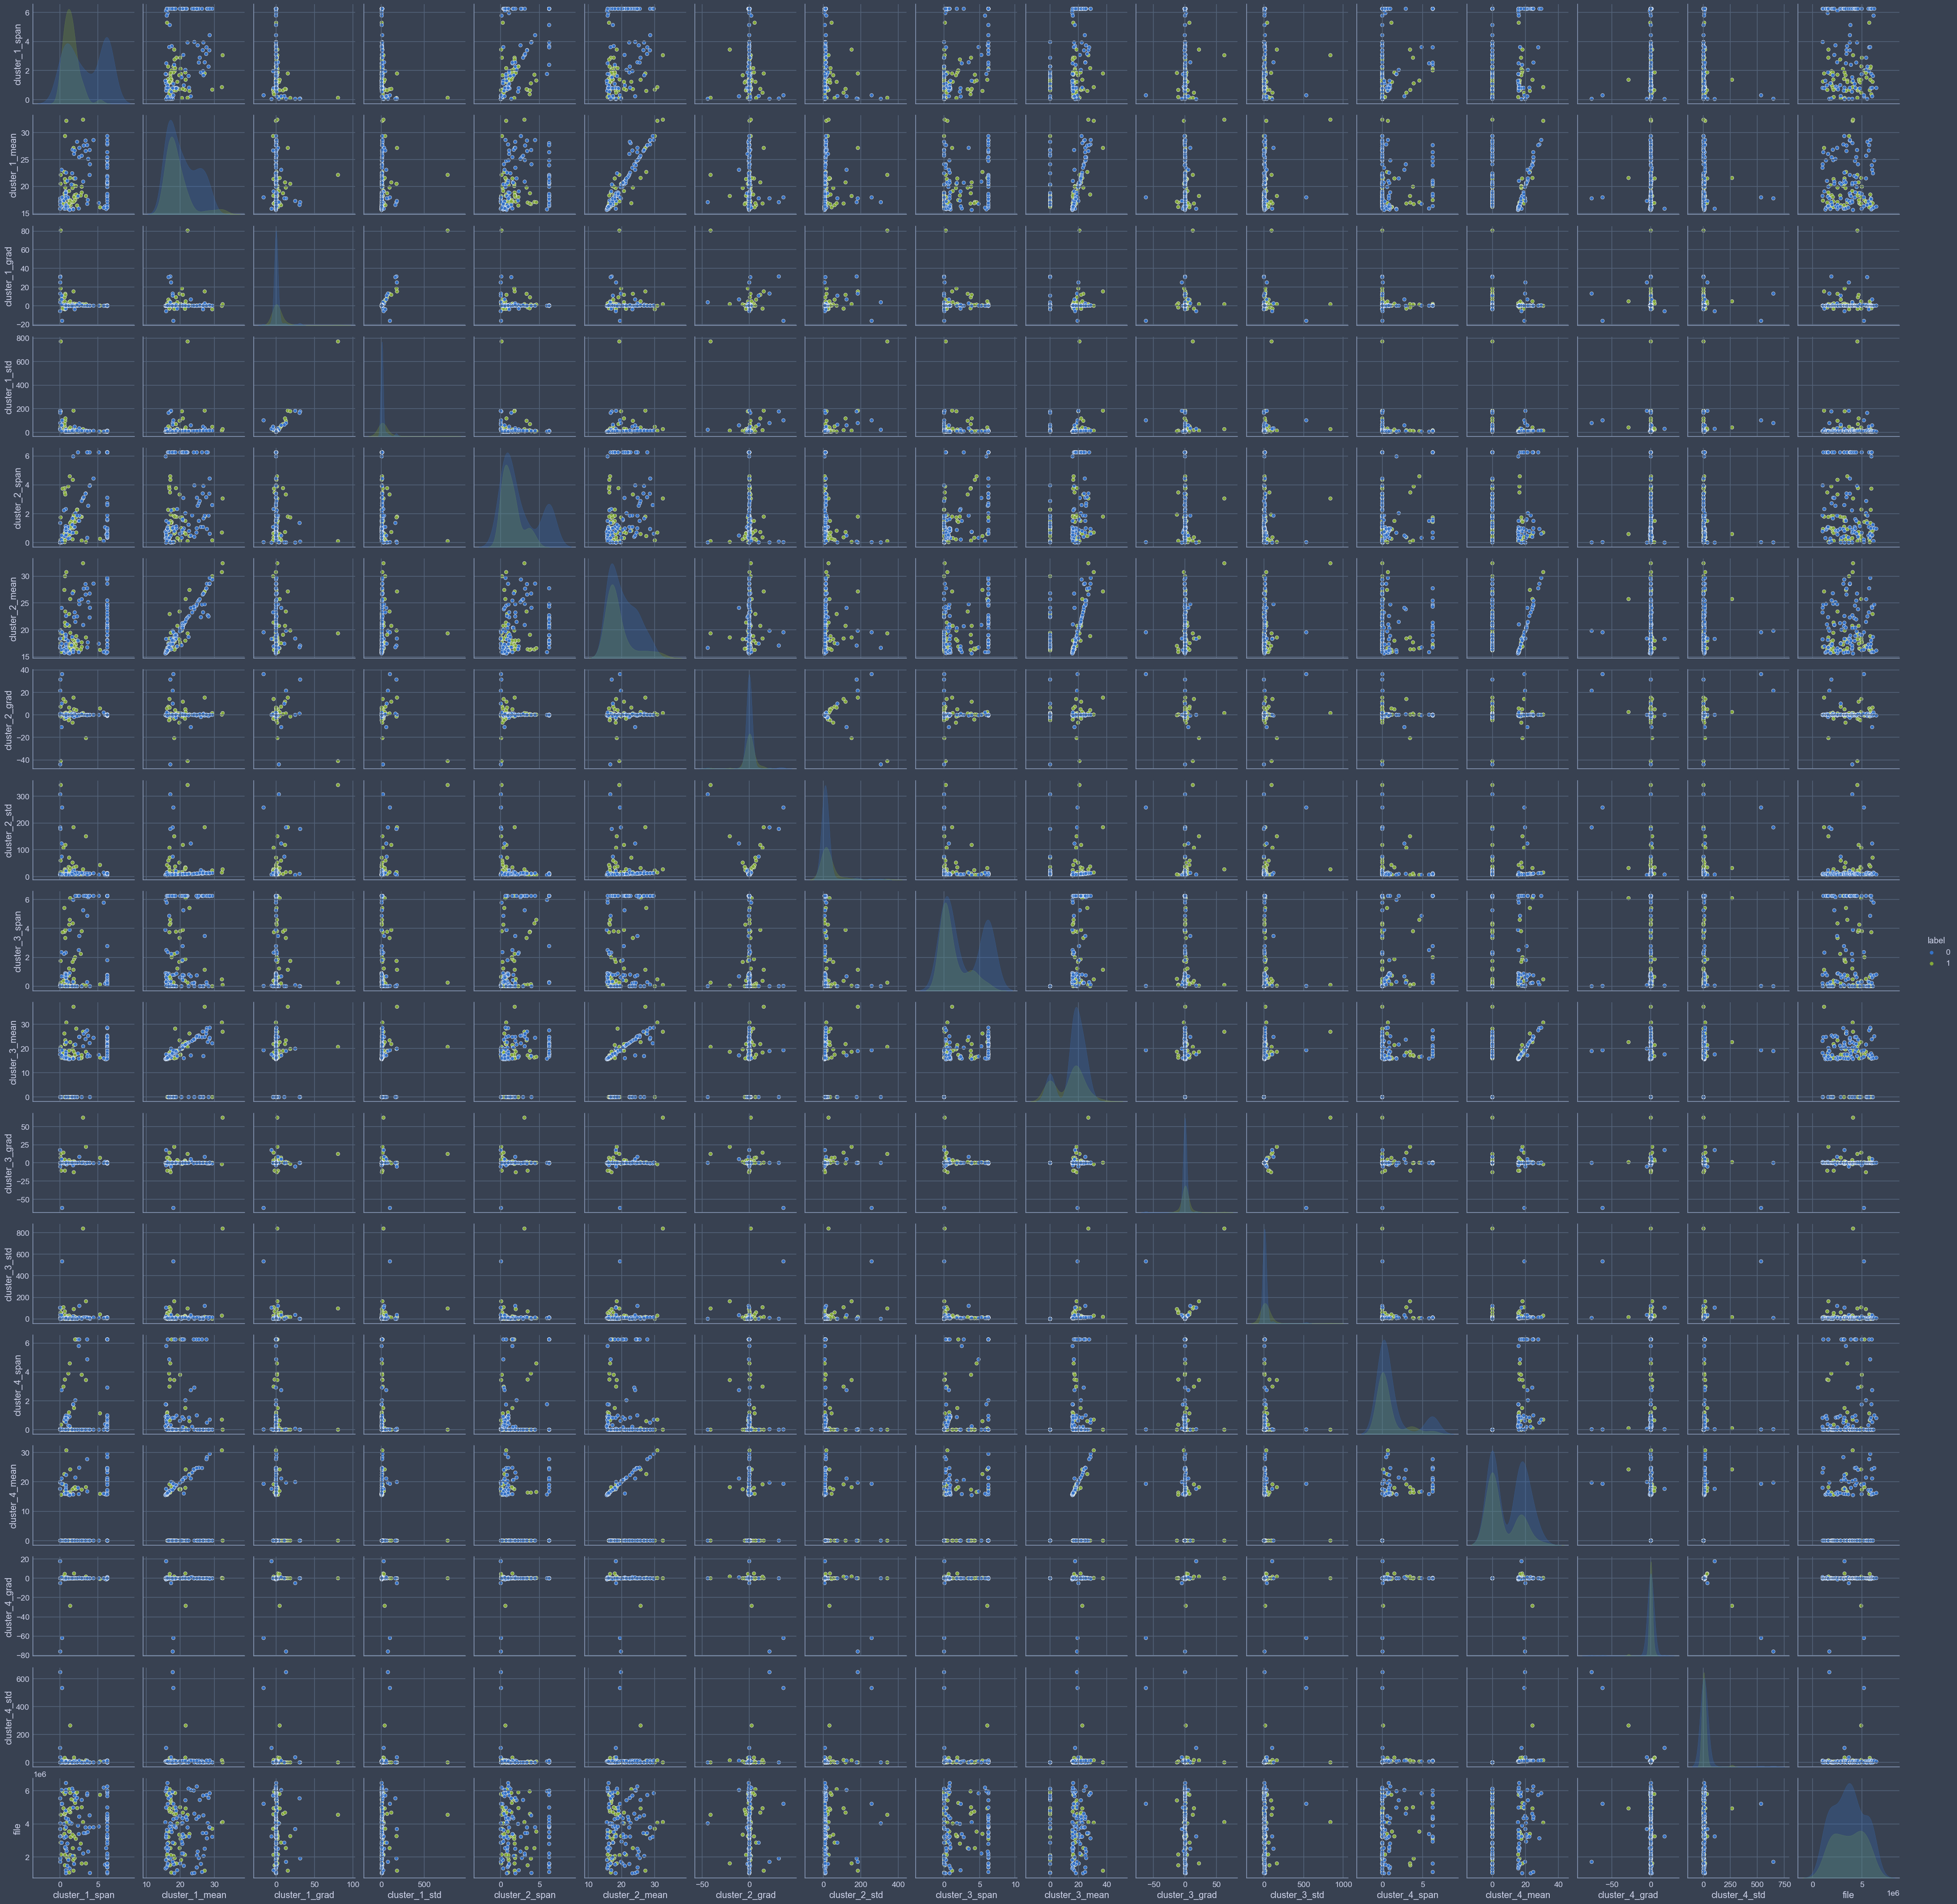

In [19]:
sns.pairplot(data.to_pandas(), hue="label")

# Model Preparation

In [156]:
import sklearn
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from joblib import parallel_backend
import optuna

from xgboost import XGBClassifier

In [90]:
X = data.drop(["label", "file"])
Y = data["label"]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True, stratify=Y)

## Support Vector Classifier

In [6]:
svc = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [7]:
with parallel_backend("threading", n_jobs=12):
    svc.fit(x_train.to_numpy(), y_train)

## Random Forest

In [8]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, n_jobs=12)
with parallel_backend("threading", n_jobs=12):
    rfc.fit(x_train.to_numpy(), y_train)

## AdaBoost

In [9]:
abc = AdaBoostClassifier(n_estimators=100, random_state=42)
with parallel_backend("threading", n_jobs=12):
    abc.fit(x_train.to_numpy(), y_train)

# Validation

In [121]:
import pp_cnf_matrix as ppcm
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay

## SVC

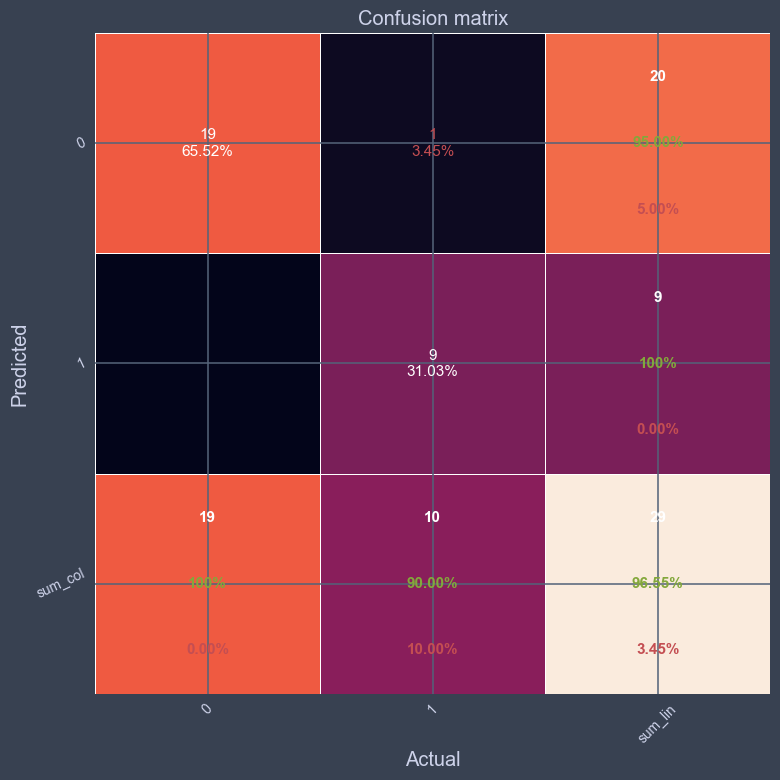

In [15]:
svc_pred = svc.predict(x_test.to_numpy())
cnf_matrix = confusion_matrix(y_test, svc_pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
ppcm.pretty_plot_confusion_matrix(cnf_matrix, cmap=sns.color_palette("rocket", as_cmap=True))

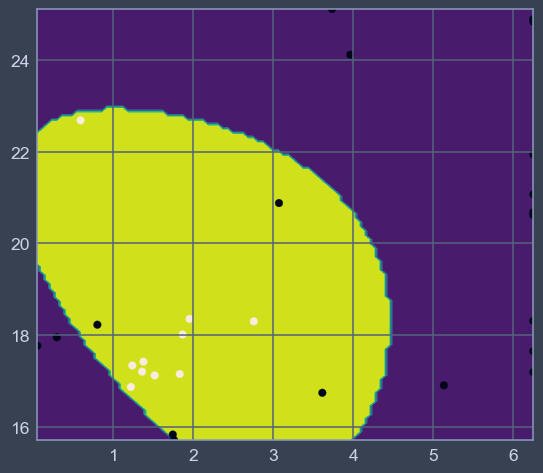

In [23]:
feature_1, feature_2 = np.meshgrid(
    np.linspace(x_test["cluster_1_span"].min(), x_test["cluster_1_span"].max(), 100),
    np.linspace(x_test["cluster_1_mean"].min(), x_test["cluster_1_mean"].max(), 100)
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
svc2 = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(x_train[["cluster_1_span", "cluster_1_mean"]].to_numpy(), y_train)
y_pred = np.reshape(svc2.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()
display.ax_.scatter(x_test["cluster_1_span"], x_test["cluster_1_mean"], c=y_test, cmap=sns.color_palette("rocket", as_cmap=True))
plt.show()

## RFC

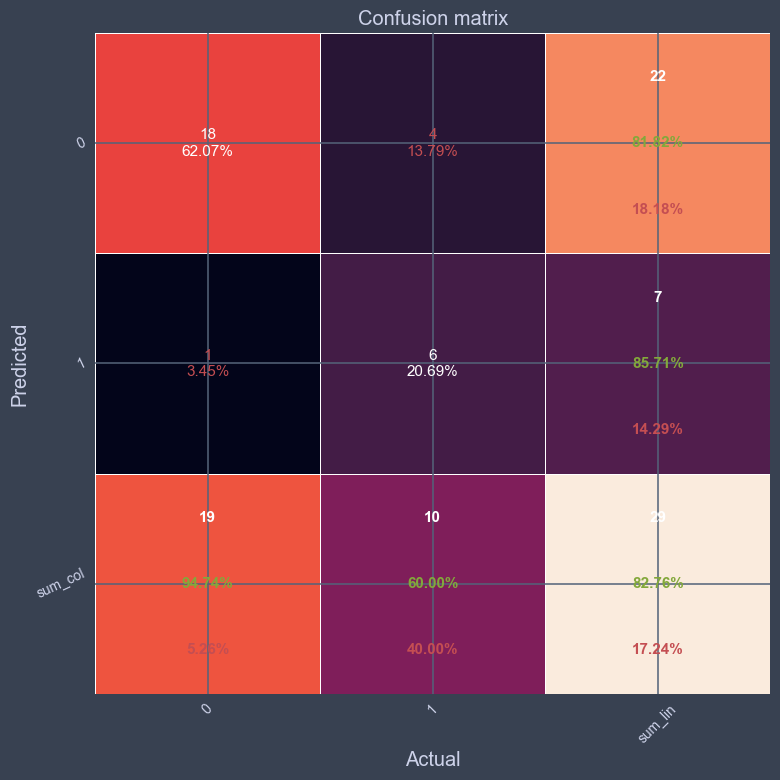

In [26]:
rfc_pred = rfc.predict(x_test.to_numpy())
cnf_matrix = confusion_matrix(y_test, rfc_pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
ppcm.pretty_plot_confusion_matrix(cnf_matrix, cmap=sns.color_palette("rocket", as_cmap=True))

## ABC

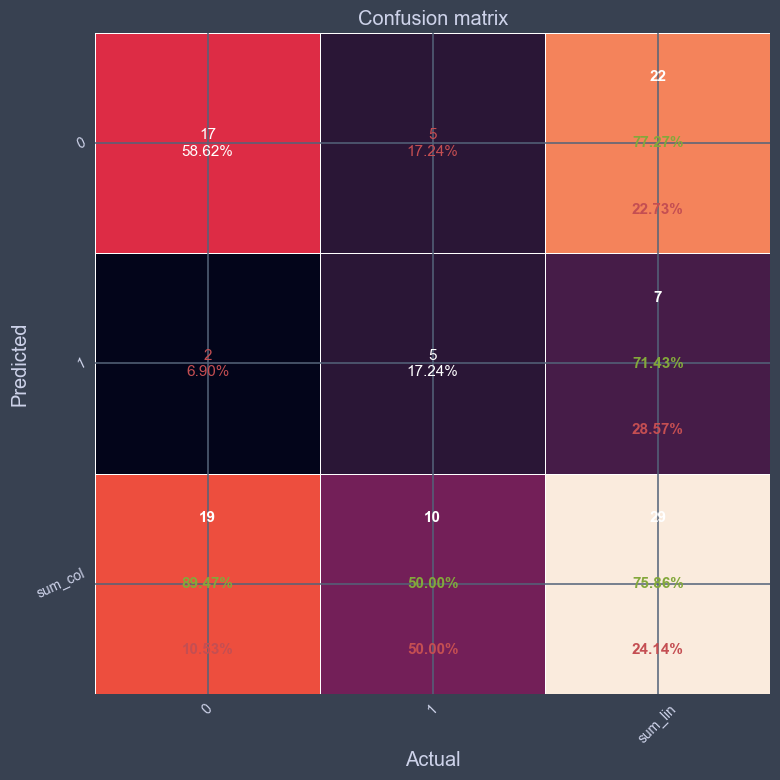

In [28]:
abc_pred = abc.predict(x_test.to_numpy())
cnf_matrix = confusion_matrix(y_test, abc_pred)
cnf_matrix = pd.DataFrame(cnf_matrix)
ppcm.pretty_plot_confusion_matrix(cnf_matrix, cmap=sns.color_palette("rocket", as_cmap=True))

# 10-Fold Cross Validation

In [153]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, auc, precision_recall_curve
from sklearn.metrics import roc_curve as sk_roc_curve
import seaborn as sns

In [23]:
sns.set_style("whitegrid")
sns.set_context("paper")

In [91]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
skf.get_n_splits(X, Y)

10

In [10]:
def ten_fold_cross_validation(skf, model, X, Y):
    outputs = []
    all_y = []
    all_preds = []
    for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
        print("---", f"Fold {i}", "---")
        model.fit(X[train_index].to_numpy(), Y[train_index])
        preds = model.predict(X[test_index].to_numpy())
        print(model.score(X[test_index].to_numpy(), Y[test_index]))
        proba = model.predict_proba(X[test_index].to_numpy())[:,1]
        outputs.append({
            "preds": preds,
            "y": Y[test_index],
            "proba": proba,
            "test_indices": test_index
        })
    return outputs

In [83]:
def k_fold_roc_curve(model_outputs, model_name:str):
    fig, ax = plt.subplots(2, 1, figsize=(8.27, 11.69), dpi=100)
    tprs, aurocs = [], []
    tpr_threshes = []
    fpr_mean = np.linspace(0, 1, 1000)
    precisions, auprcs = [], []
    recall_threshes = []
    recall_mean = np.linspace(0, 1, 1000)
    for fold_idx, fold in enumerate(tqdm(model_outputs)):
        # ROC
        fpr, tpr, tpr_thresh = sk_roc_curve(fold['y'], fold['proba'])
        tpr_threshes.append(tpr_thresh[np.abs(tpr-0.85).argmin()])
        tpr_interp = np.interp(fpr_mean, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        aurocs.append(auc(fpr, tpr))
        ax[0].plot(fpr, tpr, label="ROC Fold %d (AUC = %0.2f)" % (fold_idx, aurocs[fold_idx]), alpha=.3)
        # PRC
        precision, recall, prc_thresh = precision_recall_curve(fold['y'], fold['proba'])
        prec_interp = np.interp(recall_mean, recall[::-1], precision[::-1])
    #     prec_interp[0] = 1.0
        precisions.append(prec_interp)
        recall_threshes.append(prc_thresh[np.abs(recall-0.85).argmin()])
        auprcs.append(auc(recall, precision))
        ax[1].plot(recall, precision, label="PRC Fold %d (AUC = %0.2f)" % (fold_idx, auprcs[fold_idx]), alpha=.3)

    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[0].set_title("Receiver Operating Characteristic (ROC) Curve")
    ax[0].set_ylim(-0.1, 1.1)
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title("Precision Recall Curve")
    ax[1].set_ylim(-0.1, 1.1)

    # ROC
    tpr_mean = np.mean(tprs, axis=0)
    tpr_mean[-1] = 1.0
    auroc_mean = auc(fpr_mean, tpr_mean)
    auroc_std  = np.std(aurocs)
    ax[0].plot(fpr_mean, tpr_mean,
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (auroc_mean, auroc_std),
            lw=2, alpha=.8)
    tpr_std = np.std(tprs, axis=0)
    ax[0].fill_between(
        fpr_mean,
        np.maximum(tpr_mean-tpr_std, 0),
        np.minimum(tpr_mean+tpr_std, 1),
        alpha=.2,
        label=r"$\pm$ 1 std. dev",
        color='grey'
    )
    # PRC
    prec_mean = np.mean(precisions, axis=0)
    # prec_mean[-1] = 0.0
    auprc_mean = auc(recall_mean, prec_mean)
    auprc_std = np.std(auprcs)
    ax[1].plot(recall_mean, prec_mean,
            label=r"Mean PRC (AUC = %0.2f $\pm$ %0.2f)" % (auprc_mean, auprc_std),
            lw=2, alpha=.8)
    prec_std = np.std(precisions, axis=0)
    ax[1].fill_between(
        recall_mean,
        np.maximum(prec_mean-prec_std, 0),
        np.minimum(prec_mean+prec_std, 1),
        alpha=.2,
        label=r"$\pm$ 1 std. dev",
        color='grey'
    )

    fig.suptitle(f"ROC & PRC Curves for {model_name}")
    ax[0].legend()
    ax[1].legend()
    plt.show()

## SVC

In [92]:
svc = SVC(gamma="auto", probability=True, class_weight="balanced", kernel="rbf")
svc_10f_outputs = ten_fold_cross_validation(skf, svc, X, Y)

--- Fold 0 ---
0.76
--- Fold 1 ---
0.72
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.875
--- Fold 4 ---
0.625
--- Fold 5 ---
0.875
--- Fold 6 ---
0.75
--- Fold 7 ---
0.625
--- Fold 8 ---
0.625
--- Fold 9 ---
0.875


In [50]:
svc_10f_outputs

[{'preds': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
         0, 1, 0, 0], dtype=int64),
  'y': shape: (26,)
  Series: 'label' [i64]
  [
  	1
  	1
  	1
  	1
  	1
  	1
  	1
  	1
  	0
  	0
  	0
  	0
  	...
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  ],
  'proba': array([0.76373631, 0.89288659, 0.15657597, 0.76239324, 0.84157422,
         0.5       , 0.53386744, 0.91969224, 0.09787872, 0.53386724,
         0.22557788, 0.08373256, 0.07478428, 0.1741682 , 0.35922981,
         0.07703182, 0.11755237, 0.74787245, 0.19531161, 0.1730212 ,
         0.64333999, 0.08485097, 0.09142838, 0.40899264, 0.10140369,
         0.07652105]),
  'test_indices': array([  0,   3,  14,  25,  37,  42,  64,  67,  75,  92,  97,  99, 103,
         117, 125, 126, 145, 164, 179, 190, 200, 213, 223, 228, 238, 243])},
 {'preds': array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
         0, 0, 0, 1], dtype=int64),
  'y': shape: (26,)
  Series: '

100%|██████████| 10/10 [00:00<00:00, 588.24it/s]


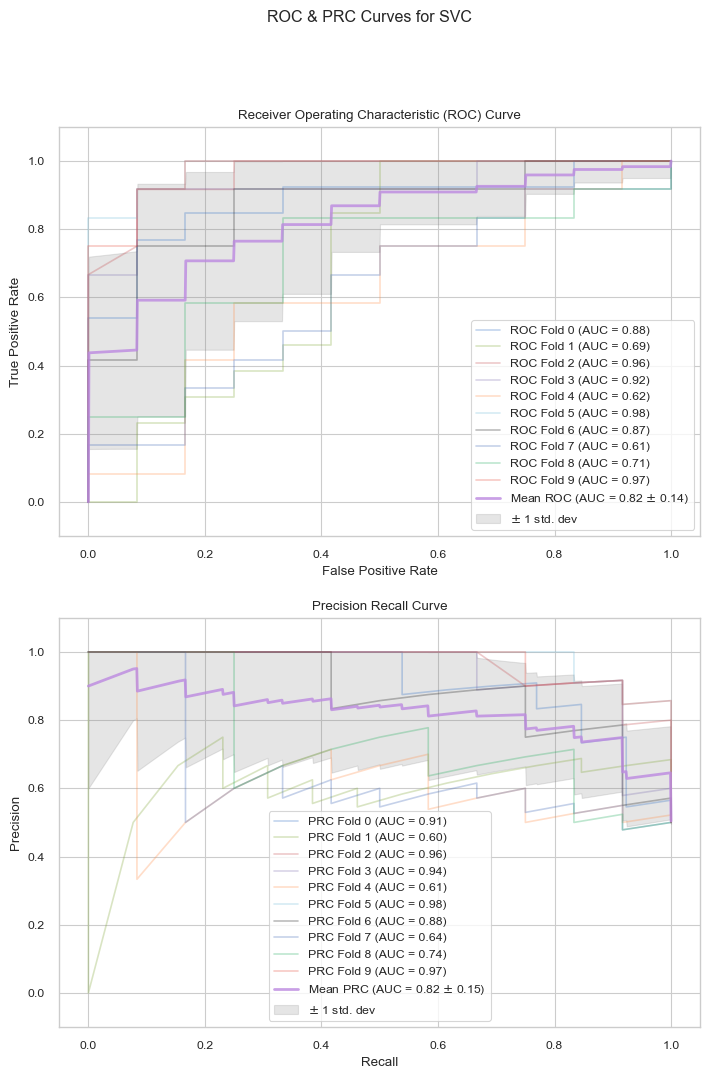

In [93]:
k_fold_roc_curve(svc_10f_outputs, "SVC")

## RFC

--- Fold 0 ---
0.88
--- Fold 1 ---
0.72
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.8333333333333334
--- Fold 4 ---
0.7083333333333334
--- Fold 5 ---
0.875
--- Fold 6 ---
0.75
--- Fold 7 ---
0.625
--- Fold 8 ---
0.75
--- Fold 9 ---
0.875


100%|██████████| 10/10 [00:00<00:00, 714.13it/s]


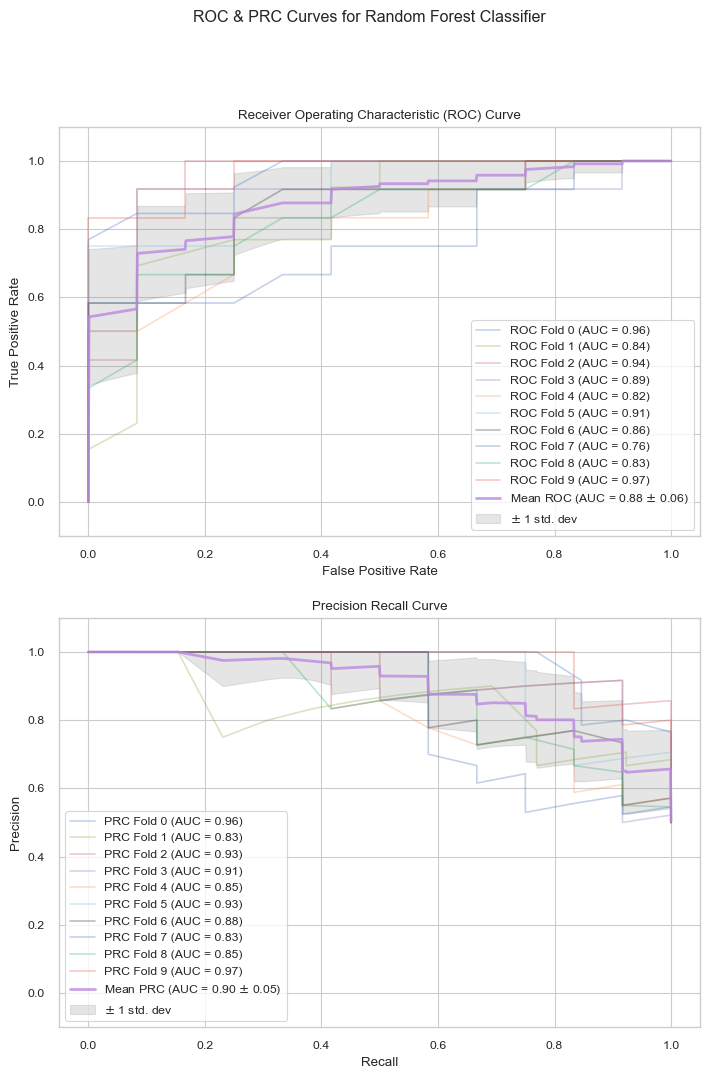

In [98]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True)
rfc_10f_outputs = ten_fold_cross_validation(skf, rfc, X, Y)
k_fold_roc_curve(rfc_10f_outputs, "Random Forest Classifier")

In [120]:
rfc_10f_outputs

[{'preds': array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
         0, 1, 0, 0], dtype=int64),
  'y': shape: (26,)
  Series: 'label' [i64]
  [
  	1
  	1
  	1
  	1
  	1
  	1
  	1
  	1
  	0
  	0
  	0
  	0
  	...
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  ],
  'proba': array([0.79, 0.83, 0.84, 0.92, 0.85, 0.29, 0.92, 0.92, 0.05, 0.43, 0.06,
         0.01, 0.02, 0.07, 0.17, 0.  , 0.01, 0.81, 0.17, 0.55, 0.91, 0.13,
         0.47, 0.88, 0.  , 0.  ]),
  'test_indices': array([  0,   3,  14,  25,  37,  42,  64,  67,  75,  92,  97,  99, 103,
         117, 125, 126, 145, 164, 179, 190, 200, 213, 223, 228, 238, 243])},
 {'preds': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 1, 0], dtype=int64),
  'y': shape: (26,)
  Series: 'label' [i64]
  [
  	1
  	1
  	1
  	1
  	1
  	1
  	1
  	1
  	0
  	0
  	0
  	0
  	...
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  	0
  ],
  'proba': array([0.9 , 0.54,

### Confusion Matrix

In [126]:
rfc_10f_y = []
rfc_10f_preds = []
for output in rfc_10f_outputs:
    rfc_10f_y.append(output["y"].to_numpy())
    rfc_10f_preds.append(output["preds"])

26
26
25
25
25
25
25
25
25
25


In [125]:
rfc_10f_y = np.concatenate(rfc_10f_y)
rfc_10f_preds = np.concatenate(rfc_10f_preds)

print(classification_report(rfc_10f_y, rfc_10f_preds))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       179
           1       0.75      0.75      0.75        73

    accuracy                           0.86       252
   macro avg       0.83      0.83      0.83       252
weighted avg       0.86      0.86      0.86       252



In [113]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter Tuning

In [141]:
rfc = RandomForestClassifier(n_jobs=12, random_state=42, bootstrap=True)
dist = {
    "n_estimators": [1, 2, 4, 8, 16, 32, 50, 64, 100, 128, 256, 512, 1024],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 1, 2, 4, 8, 16, 32, 64, 128],
    "min_samples_split": [0.1, 0.2, 0.4, 0.5, 2, 3],
    "min_samples_leaf": [0.1, 0.2, 0.4, 0.5, 1, 2, 3],
    "max_features": ["sqrt", "log2", None],
    "oob_score": [True, False],
    # "warm_start": [True, False],
    "class_weight": [None, "balanced", "balanced_subsample"],
    "ccp_alpha": [0.0, 0.1, 0.2, 0.5, 0.75, 1.0],
    "max_samples": [0.1, 0.2, 0.5, 0.75, 1.0, 1, 2, 3, 4],
}
rs = RandomizedSearchCV(rfc, dist, random_state=42, n_iter=60, scoring="roc_auc", verbose=1, error_score="raise")
with parallel_backend("threading", n_jobs=12):
    search = rs.fit(X.to_numpy(), Y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-pa

In [142]:
rs.best_params_

{'oob_score': True,
 'n_estimators': 512,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'entropy',
 'class_weight': None,
 'ccp_alpha': 0.1}

--- Fold 0 ---
0.68
--- Fold 1 ---
0.72
--- Fold 2 ---
0.625
--- Fold 3 ---
0.7916666666666666
--- Fold 4 ---
0.5833333333333334
--- Fold 5 ---
0.7916666666666666
--- Fold 6 ---
0.7083333333333334
--- Fold 7 ---
0.6666666666666666
--- Fold 8 ---
0.5833333333333334
--- Fold 9 ---
0.7916666666666666


100%|██████████| 10/10 [00:00<00:00, 769.27it/s]


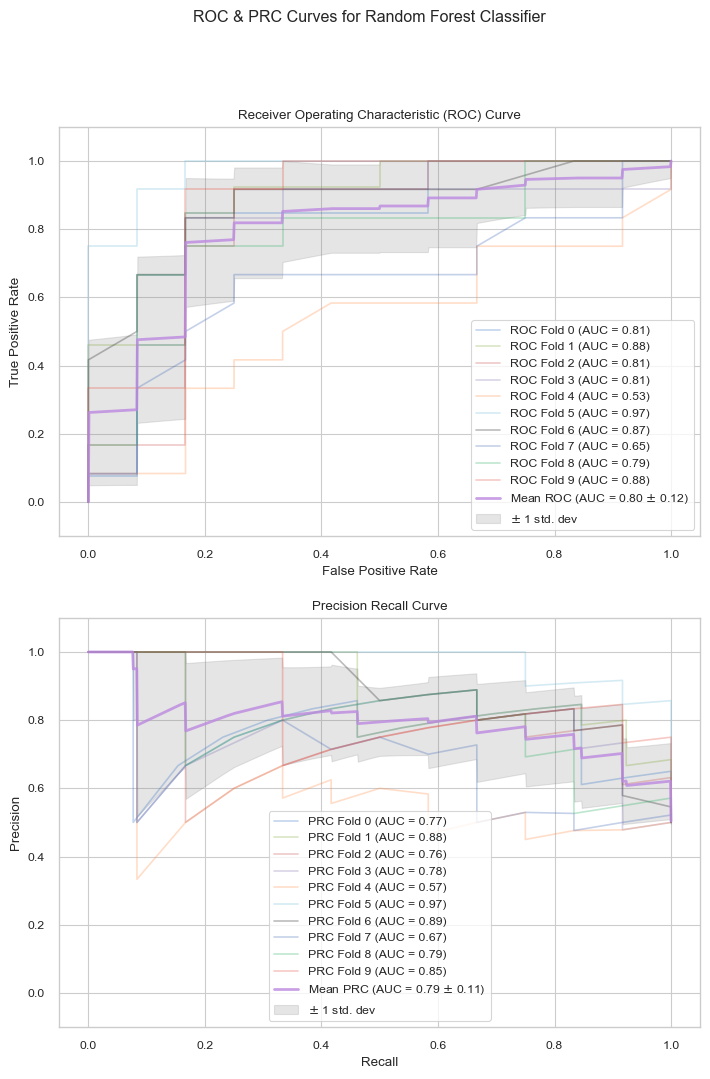

In [143]:
rfc_10f_outputs = ten_fold_cross_validation(skf, rs.best_estimator_, X, Y)
k_fold_roc_curve(rfc_10f_outputs, "Random Forest Classifier")

In [138]:
class RFC_Objective(object):
    def __init__(self, X, Y, skf):
        self.X = X.to_numpy()
        self.Y = Y
        self.skf = skf
    
    def __call__(self, trial):
        n_estimators = trial.suggest_int("n_estimators", 1, 1024, log=True)
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
        max_depth = trial.suggest_categorical("max_depth", [None, 1, 2, 4, 8, 16, 32, 64, 128])
        # min_samples_split = trial.suggest_float("min_samples_split", 0.01, 1.0, log=True)
        # min_samples_leaf = trial.suggest_float("min_samples_leaf", 0.01, 1.0, log=True)
        max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        oob_score = trial.suggest_categorical("oob_score", [True, False])
        # warm_start = trial.suggest_categorical("warm_start", [True, False])
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"])
        # ccp_alpha = trial.suggest_float("ccp_alpha", 1e-5, 1.0, log=True)
        max_samples = trial.suggest_categorical("max_samples", [0.1, 0.2, 0.5, 0.75, 1.0, 1, 2, 3, 4])
        clf = RandomForestClassifier(
            n_jobs=12,
            random_state=42, 
            bootstrap=True,
            n_estimators=n_estimators,
            criterion=criterion,
            max_depth=max_depth,
            # min_samples_split=min_samples_split,
            # min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            oob_score=oob_score,
            # warm_start=warm_start,
            class_weight=class_weight,
            # ccp_alpha=ccp_alpha,
            max_samples=max_samples
        )
        score = cross_val_score(clf, self.X, self.Y, n_jobs=12, cv=self.skf, scoring="roc_auc")
        return score.mean()
    

In [139]:
rfc_objective = RFC_Objective(X, Y, skf)
study = optuna.create_study(direction="maximize")
study.optimize(rfc_objective, n_trials=150)
study.best_trial

[I 2023-04-07 12:57:24,284] A new study created in memory with name: no-name-df30fd8e-6d11-4a8d-857e-36eff947b66a
[I 2023-04-07 12:57:24,306] Trial 0 finished with value: 0.5865384615384615 and parameters: {'n_estimators': 1, 'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'oob_score': False, 'class_weight': 'balanced_subsample', 'max_samples': 0.75}. Best is trial 0 with value: 0.5865384615384615.
[I 2023-04-07 12:57:24,373] Trial 1 finished with value: 0.7153579059829059 and parameters: {'n_estimators': 26, 'criterion': 'log_loss', 'max_depth': 16, 'max_features': 'sqrt', 'oob_score': False, 'class_weight': 'balanced_subsample', 'max_samples': 4}. Best is trial 1 with value: 0.7153579059829059.
[I 2023-04-07 12:57:24,392] Trial 2 finished with value: 0.7608974358974359 and parameters: {'n_estimators': 1, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'oob_score': True, 'class_weight': 'balanced', 'max_samples': 0.75}. Best is trial 2 with value: 0.76089

FrozenTrial(number=147, state=TrialState.COMPLETE, values=[0.8765491452991453], datetime_start=datetime.datetime(2023, 4, 7, 12, 58, 5, 74369), datetime_complete=datetime.datetime(2023, 4, 7, 12, 58, 5, 411369), params={'n_estimators': 144, 'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'oob_score': True, 'class_weight': 'balanced_subsample', 'max_samples': 0.5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1024, log=True, low=1, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'max_depth': CategoricalDistribution(choices=(None, 1, 2, 4, 8, 16, 32, 64, 128)), 'max_features': CategoricalDistribution(choices=('sqrt', 'log2', None)), 'oob_score': CategoricalDistribution(choices=(True, False)), 'class_weight': CategoricalDistribution(choices=(None, 'balanced', 'balanced_subsample')), 'max_samples': CategoricalDistribution(choices=(0.1, 0.2, 0.5, 0.75, 1.0, 1, 2, 3, 4))}, 

--- Fold 0 ---
0.8
--- Fold 1 ---
0.72
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.875
--- Fold 4 ---
0.5833333333333334
--- Fold 5 ---
0.875
--- Fold 6 ---
0.7083333333333334
--- Fold 7 ---
0.625
--- Fold 8 ---
0.7916666666666666
--- Fold 9 ---
0.8333333333333334


100%|██████████| 10/10 [00:00<00:00, 624.91it/s]


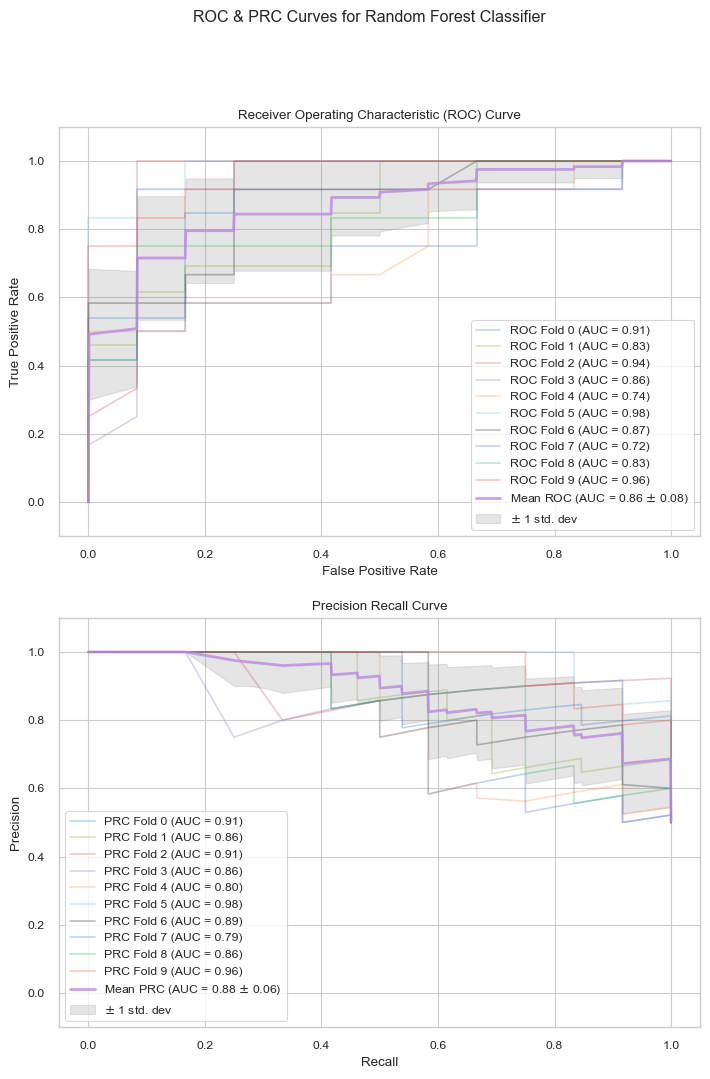

In [175]:
rfc_optimised = RandomForestClassifier(
    n_estimators=144,
    criterion="entropy",
    max_depth=32,
    # min_samples_split=0.04660769387488283,
    # min_samples_leaf=0.010044120060292563,
    max_features="log2",
    oob_score=True,
    # warm_start=False,
    class_weight="balanced_subsample",
    # ccp_alpha=0.018493473306628785,
    max_samples=0.5
)
rfc_opt_10f_outputs = ten_fold_cross_validation(skf, rfc_optimised, X, Y)
k_fold_roc_curve(rfc_opt_10f_outputs, "Random Forest Classifier")

#### Confusion Matrix

In [185]:
rfc_10f_y = []
rfc_10f_preds = []
for output in rfc_opt_10f_outputs:
    rfc_10f_y.append(output["y"].to_numpy())
    rfc_10f_preds.append(output["preds"])

rfc_10f_y = np.concatenate(rfc_10f_y)
rfc_10f_preds = np.concatenate(rfc_10f_preds)

print(classification_report(rfc_10f_y, rfc_10f_preds, digits=4))

              precision    recall  f1-score   support

           0     0.7826    0.7500    0.7660       120
           1     0.7638    0.7951    0.7791       122

    accuracy                         0.7727       242
   macro avg     0.7732    0.7725    0.7725       242
weighted avg     0.7731    0.7727    0.7726       242



### Ablation Study

In [118]:
results = [rfc_opt_10f_outputs]
for clusters_drop in tqdm([("4"), ("4", "3"), ("4", "3", "2")]):
    cols = []
    for cluster in clusters_drop:
        cols += [f"cluster_{cluster}_span", f"cluster_{cluster}_min_amp", f"cluster_{cluster}_max_amp", f"cluster_{cluster}_height_amp", f"cluster_{cluster}_mean_amp", f"cluster_{cluster}_grad", f"cluster_{cluster}_std"]
    X_ablation = X.drop(cols)
    skf_ablation = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    skf_ablation.get_n_splits(X_ablation, Y)
    # rfc_ablation = RandomForestClassifier(n_estimators=100, n_jobs=12, random_state=42, bootstrap=True)
    rfc_ablation = RandomForestClassifier(
        n_estimators=144,
        random_state=42,
        criterion="entropy",
        max_depth=32,
        max_features="log2",
        oob_score=True,
        class_weight="balanced_subsample",
        max_samples=0.5
    )
    skf_results = ten_fold_cross_validation(skf_ablation, rfc_ablation, X_ablation, Y)
    results.append(skf_results)

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


--- Fold 0 ---
0.72
--- Fold 1 ---
0.88
--- Fold 2 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.875
--- Fold 3 ---
0.875
--- Fold 4 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.625
--- Fold 5 ---
0.9166666666666666
--- Fold 6 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.8333333333333334
--- Fold 7 ---
0.5416666666666666
--- Fold 8 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.7916666666666666
--- Fold 9 ---
0.8333333333333334
--- Fold 0 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


0.72
--- Fold 1 ---
0.88
--- Fold 2 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.875
--- Fold 3 ---
0.875
--- Fold 4 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.625
--- Fold 5 ---
0.9166666666666666
--- Fold 6 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.8333333333333334
--- Fold 7 ---
0.5833333333333334
--- Fold 8 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.7916666666666666
--- Fold 9 ---
0.8333333333333334
--- Fold 0 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(


0.72
--- Fold 1 ---
0.88
--- Fold 2 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.8333333333333334
--- Fold 3 ---
0.875
--- Fold 4 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.6666666666666666
--- Fold 5 ---
0.9166666666666666
--- Fold 6 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.8333333333333334
--- Fold 7 ---
0.625
--- Fold 8 ---


c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
c:\Users\chris\.virtualenvs\INF2008-XgWG3lwF\lib\site-packages\sklearn\ensemble\_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "ba

0.7916666666666666
--- Fold 9 ---
0.8333333333333334


100%|██████████| 10/10 [00:00<00:00, 714.43it/s]


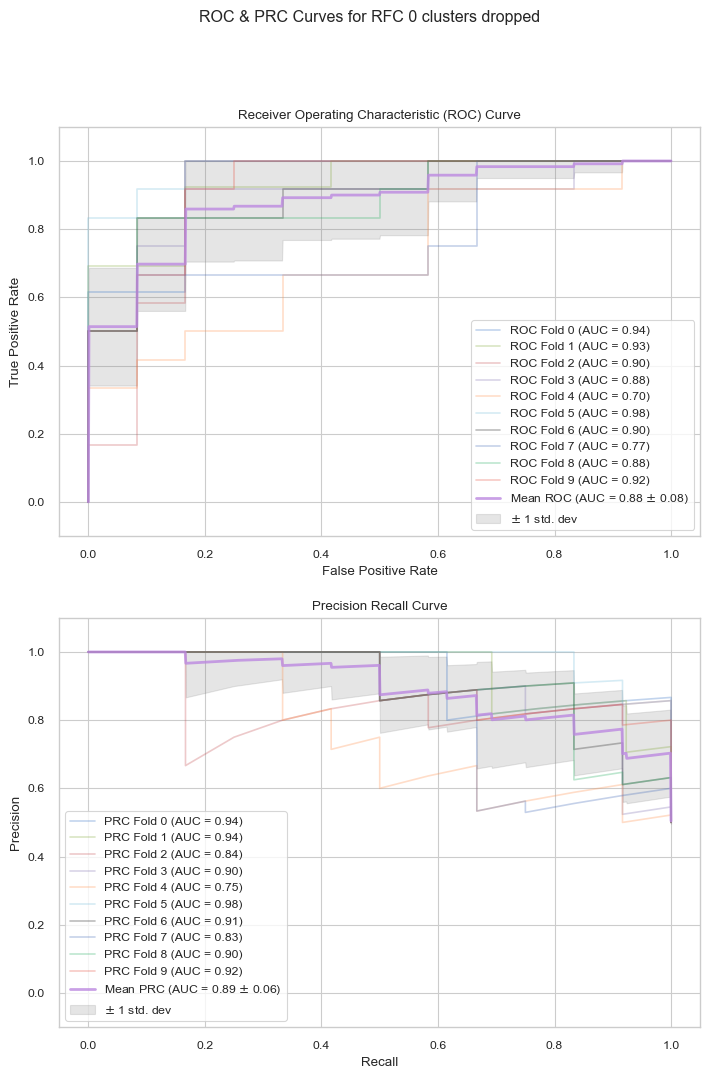

100%|██████████| 10/10 [00:00<00:00, 588.29it/s]


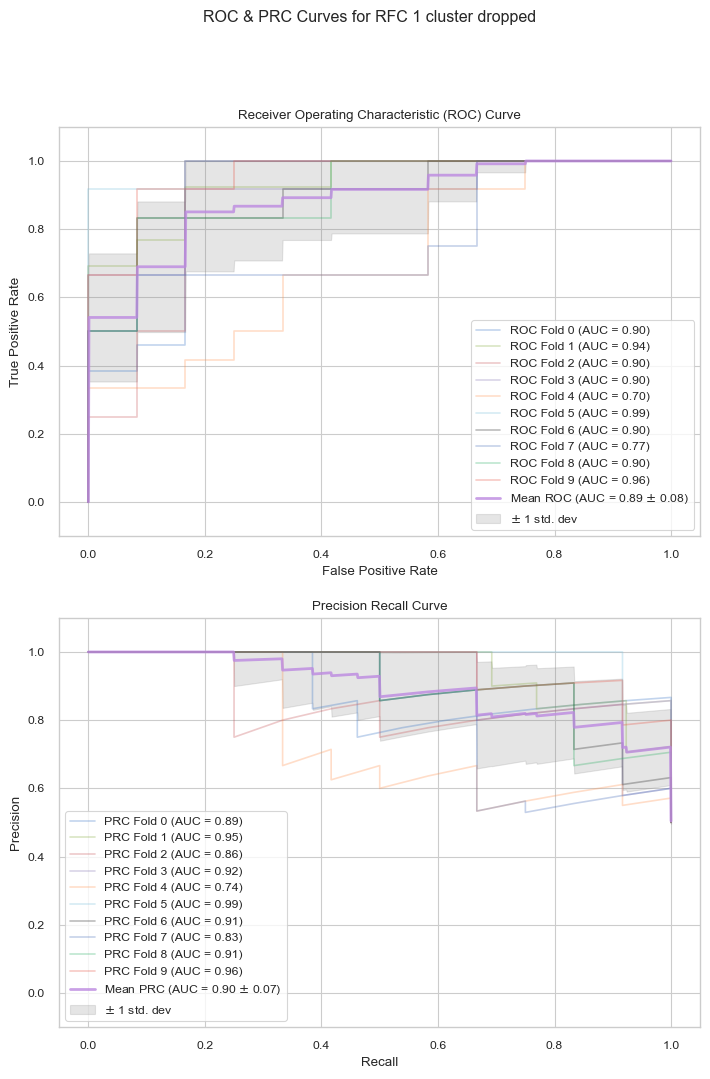

100%|██████████| 10/10 [00:00<00:00, 769.44it/s]


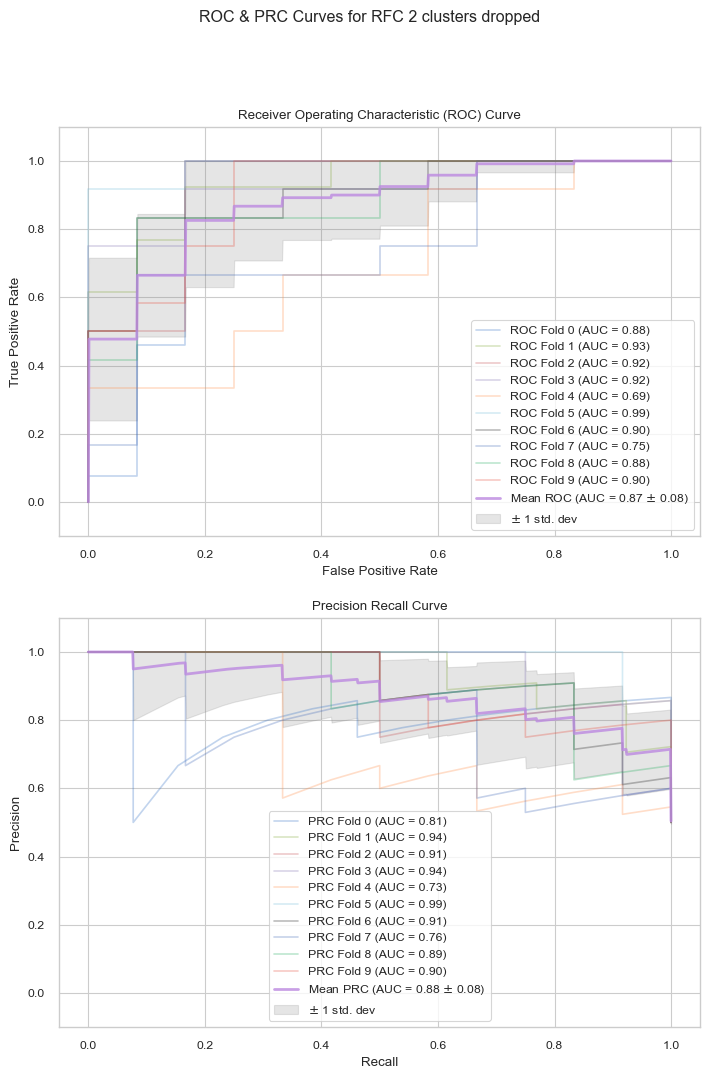

100%|██████████| 10/10 [00:00<00:00, 769.12it/s]


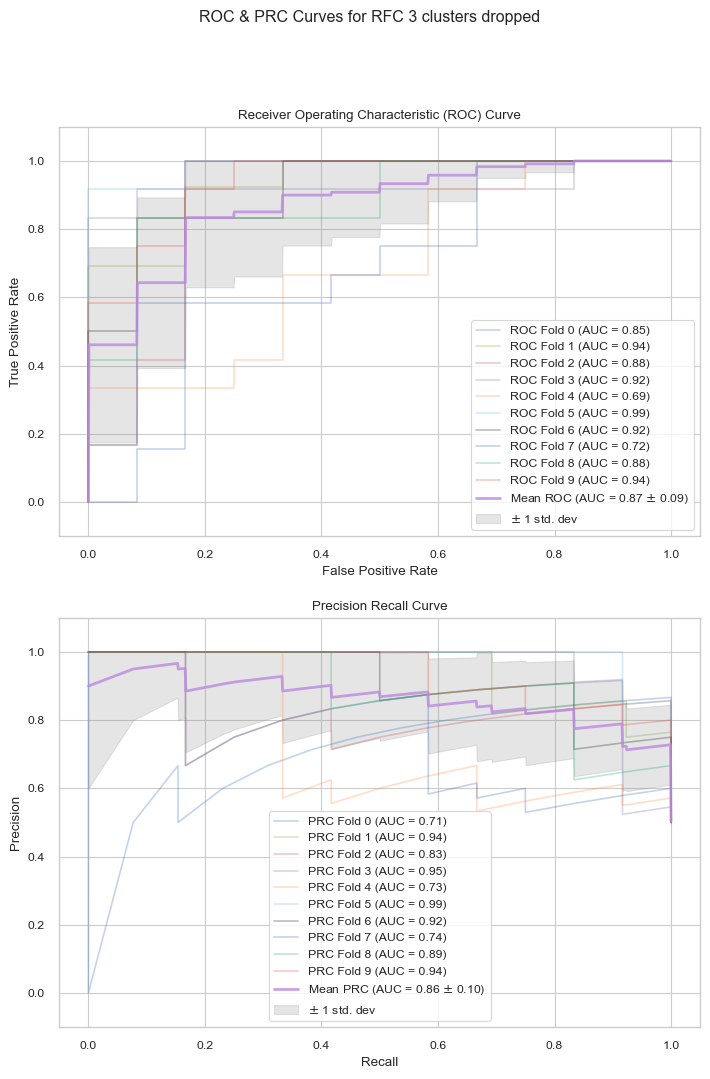

In [119]:
for result in zip(results, ["0 clusters dropped", "1 cluster dropped", "2 clusters dropped", "3 clusters dropped"]):
    k_fold_roc_curve(result[0], f"RFC {result[1]}")

In [160]:
X_new = MinMaxScaler((0.0, 1.0)).fit_transform(X.to_numpy())
selector= SelectKBest(chi2, k=10)
selector.fit(X_new, Y)
cols_idx = selector.get_support(indices=True)
X[:, ].head()

ValueError: Cannot __getitem__ on DataFrame with item: '[0, 8, 9, 10, 11, 14, 15, 16, 17, 18]' of type: '<class 'list'>'.

In [188]:
chi2(X_new, Y)[0]

array([4.68949650e+00, 4.03608365e+00, 6.20516140e-01, 2.67291990e+00,
       2.81525238e-01, 9.21299676e-02, 1.01830780e+00, 3.30047448e+00,
       5.77488341e+00, 8.72211479e+00, 5.77618764e+00, 6.66673563e+00,
       2.32130320e-01, 1.39538028e+00, 6.52704040e+00, 5.71774741e+00,
       1.01237851e+01, 6.43853873e+00, 8.32596503e+00, 9.24151234e-04,
       3.93807651e+00, 5.83932480e-01, 7.21053204e-03, 3.62438066e-01,
       1.00787294e+00, 1.78113338e-01, 3.66399285e-04, 6.73956455e-01])

In [189]:
np.argsort(chi2(X_new, Y)[0])[::-1]

array([16,  9, 18, 11, 14, 17, 10,  8, 15,  0,  1, 20,  7,  3, 13,  6, 24,
       27,  2, 21, 23,  4, 12, 25,  5, 22, 19, 26], dtype=int64)

In [164]:
top_cols = [X.columns[i] for i in cols_idx]

In [194]:
rev_importance_cols = [X.columns[i] for i in np.argsort(chi2(X_new, Y)[0])[::-1]]

In [197]:
rev_imp_cols = []
for i, col in enumerate(rev_importance_cols):
    rev_imp_cols.append(rev_importance_cols[:i])

In [201]:
X[rev_imp_cols[-1]]

shape: (242, 27)
┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ cluster_3_ ┆ cluster_2_ ┆ cluster_3_ ┆ cluster_2_ ┆ … ┆ cluster_4_ ┆ cluster_1_ ┆ cluster_4_ ┆ cluster_3_ │
│ max_amp    ┆ max_amp    ┆ mean_amp   ┆ mean_amp   ┆   ┆ mean_amp   ┆ grad       ┆ min_amp    ┆ grad       │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ -0.000554  ┆ 0.0        ┆ 0.0        │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ -0.000137  ┆ 0.0        ┆ 0.0        │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.197063   ┆ 0.0        ┆ 0.0        │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.00154    ┆ 0.0        ┆ 0.0        │
│ …          ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ -0.000158  ┆ 0.0        ┆ 0.0        │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.002911   ┆ 0.0        ┆ 0.0        │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.002803   ┆ 0.0        ┆ 0.0        │
│ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.001819   ┆ 0.0        ┆ 0.0        │
└────────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴────────────┴────────────┘

In [166]:
X[top_cols]

shape: (242, 10)
┌────────────┬────────────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ cluster_1_ ┆ cluster_2_ ┆ cluster_2_ ┆ cluster_2_ ┆ … ┆ cluster_3_ ┆ cluster_3_ ┆ cluster_3_ ┆ cluster_3_ │
│ span       ┆ min_amp    ┆ max_amp    ┆ height_amp ┆   ┆ min_amp    ┆ max_amp    ┆ height_amp ┆ mean_amp   │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ f64        ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 6.248279   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 6.248279   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 6.248279   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 6.161012   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ …          ┆ …          ┆ …          ┆ …          ┆ … ┆ …          ┆ …          ┆ …          ┆ …          │
│ 6.248279   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 6.230825   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 6.248279   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
│ 6.248279   ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ … ┆ 0.0        ┆ 0.0        ┆ 0.0        ┆ 0.0        │
└────────────┴────────────┴────────────┴────────────┴───┴────────────┴────────────┴────────────┴────────────┘

### Ablation by Feature Type

In [202]:
results = [rfc_opt_10f_outputs]
for feature_drop in tqdm([["max_amp"], ["max_amp", "mean_amp"], ["max_amp", "mean_amp", "span", "height_amp"], ["span", "min_amp", "max_amp", "height_amp", "mean_amp", "std"]]):
    cols = []
    for feature in feature_drop:
        cols += [f"cluster_{i}_{feature}" for i in range(1, 5)]
    print(cols)
    X_ablation = X.drop(cols)
    skf_ablation = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    skf_ablation.get_n_splits(X_ablation, Y)
    # rfc_ablation = RandomForestClassifier(n_estimators=100, n_jobs=12, random_state=42, bootstrap=True)
    rfc_ablation = RandomForestClassifier(
        n_estimators=144,
        random_state=42,
        criterion="entropy",
        max_depth=32,
        max_features="log2",
        oob_score=True,
        class_weight="balanced_subsample",
        max_samples=0.5
    )
    skf_results = ten_fold_cross_validation(skf_ablation, rfc_ablation, X_ablation, Y)
    results.append(skf_results)

  0%|          | 0/4 [00:00<?, ?it/s]

['cluster_1_max_amp', 'cluster_2_max_amp', 'cluster_3_max_amp', 'cluster_4_max_amp']
--- Fold 0 ---
0.8
--- Fold 1 ---
0.76
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.8333333333333334
--- Fold 4 ---
0.5416666666666666
--- Fold 5 ---
0.9166666666666666
--- Fold 6 ---
0.7083333333333334
--- Fold 7 ---
0.5416666666666666
--- Fold 8 ---
0.75
--- Fold 9 ---
0.8333333333333334


 25%|██▌       | 1/4 [00:01<00:05,  1.95s/it]

['cluster_1_max_amp', 'cluster_2_max_amp', 'cluster_3_max_amp', 'cluster_4_max_amp', 'cluster_1_mean_amp', 'cluster_2_mean_amp', 'cluster_3_mean_amp', 'cluster_4_mean_amp']
--- Fold 0 ---
0.8
--- Fold 1 ---
0.72
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.8333333333333334
--- Fold 4 ---
0.625
--- Fold 5 ---
0.9583333333333334
--- Fold 6 ---
0.75
--- Fold 7 ---
0.5416666666666666
--- Fold 8 ---
0.75
--- Fold 9 ---


 50%|█████     | 2/4 [00:03<00:03,  1.93s/it]

0.8333333333333334
['cluster_1_max_amp', 'cluster_2_max_amp', 'cluster_3_max_amp', 'cluster_4_max_amp', 'cluster_1_mean_amp', 'cluster_2_mean_amp', 'cluster_3_mean_amp', 'cluster_4_mean_amp', 'cluster_1_span', 'cluster_2_span', 'cluster_3_span', 'cluster_4_span', 'cluster_1_height_amp', 'cluster_2_height_amp', 'cluster_3_height_amp', 'cluster_4_height_amp']
--- Fold 0 ---
0.72
--- Fold 1 ---
0.76
--- Fold 2 ---
0.8333333333333334
--- Fold 3 ---
0.7916666666666666
--- Fold 4 ---
0.6666666666666666
--- Fold 5 ---
0.7916666666666666
--- Fold 6 ---
0.7916666666666666
--- Fold 7 ---
0.5
--- Fold 8 ---
0.75
--- Fold 9 ---


 75%|███████▌  | 3/4 [00:05<00:01,  1.93s/it]

0.8333333333333334
['cluster_1_span', 'cluster_2_span', 'cluster_3_span', 'cluster_4_span', 'cluster_1_min_amp', 'cluster_2_min_amp', 'cluster_3_min_amp', 'cluster_4_min_amp', 'cluster_1_max_amp', 'cluster_2_max_amp', 'cluster_3_max_amp', 'cluster_4_max_amp', 'cluster_1_height_amp', 'cluster_2_height_amp', 'cluster_3_height_amp', 'cluster_4_height_amp', 'cluster_1_mean_amp', 'cluster_2_mean_amp', 'cluster_3_mean_amp', 'cluster_4_mean_amp', 'cluster_1_std', 'cluster_2_std', 'cluster_3_std', 'cluster_4_std']
--- Fold 0 ---
0.8
--- Fold 1 ---
0.68
--- Fold 2 ---
0.7083333333333334
--- Fold 3 ---
0.6666666666666666
--- Fold 4 ---
0.625
--- Fold 5 ---
0.75
--- Fold 6 ---
0.75
--- Fold 7 ---
0.5
--- Fold 8 ---
0.7083333333333334
--- Fold 9 ---
0.6666666666666666


100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


100%|██████████| 10/10 [00:00<00:00, 555.58it/s]


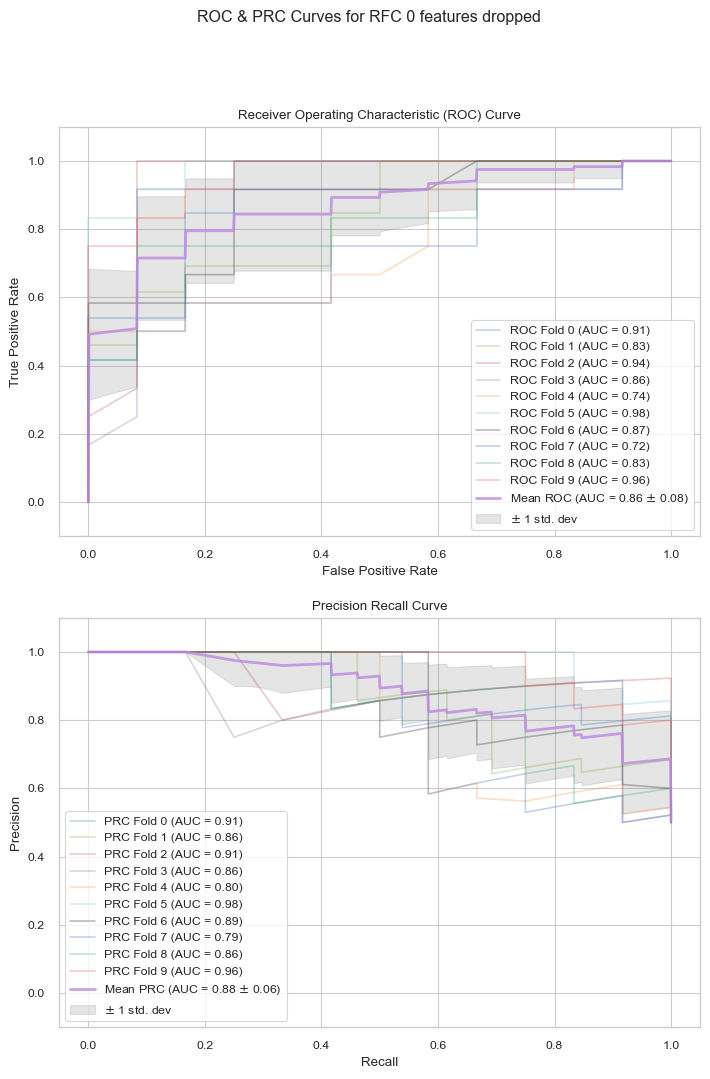

100%|██████████| 10/10 [00:00<00:00, 769.09it/s]


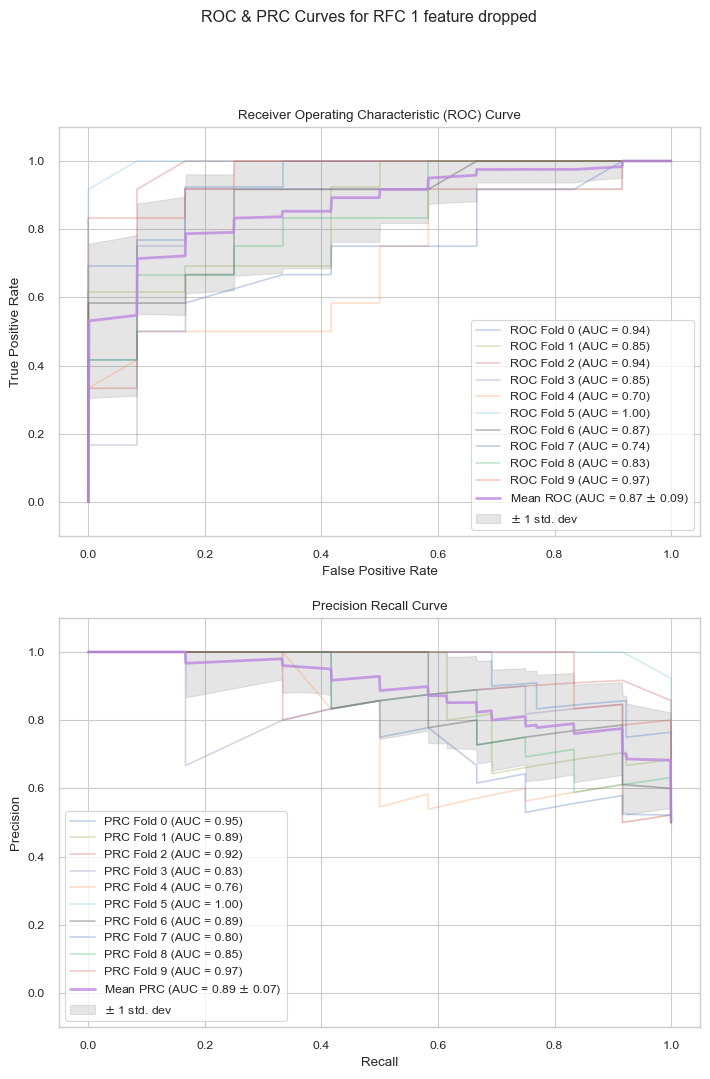

100%|██████████| 10/10 [00:00<00:00, 499.91it/s]


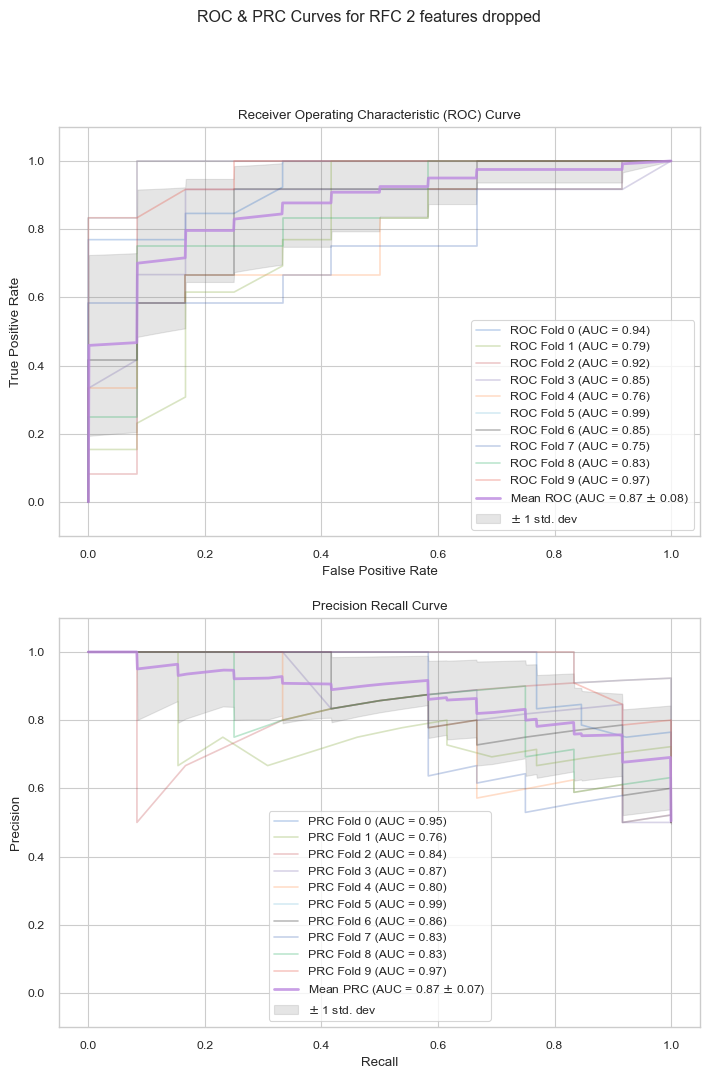

100%|██████████| 10/10 [00:00<00:00, 666.58it/s]


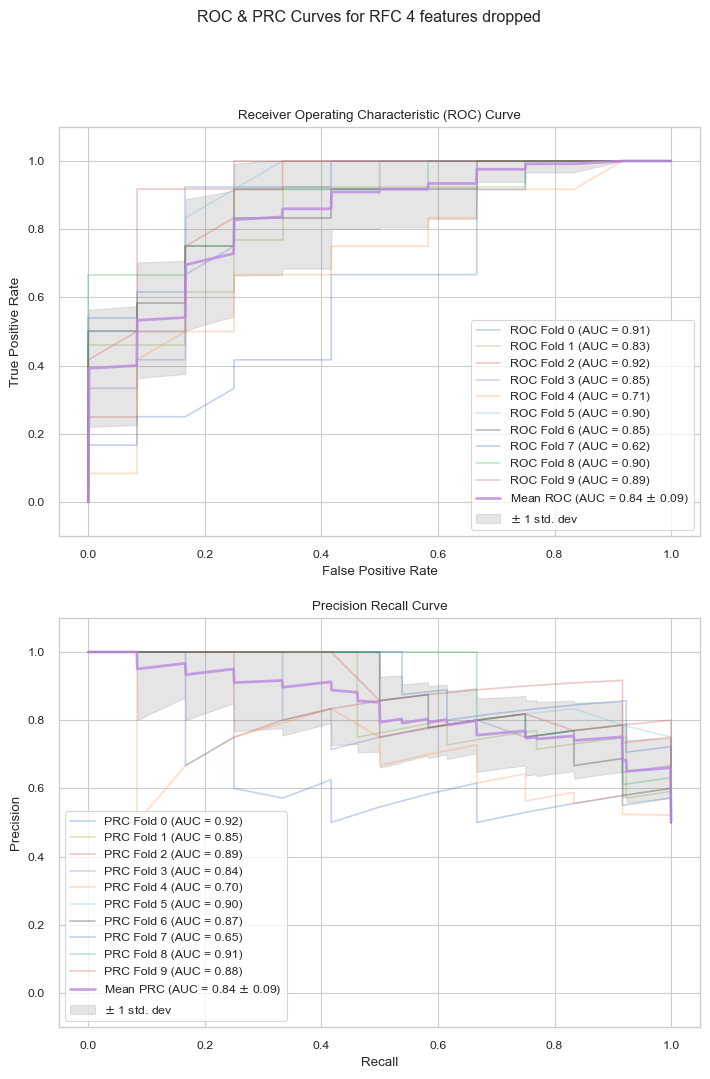

100%|██████████| 10/10 [00:00<00:00, 714.34it/s]


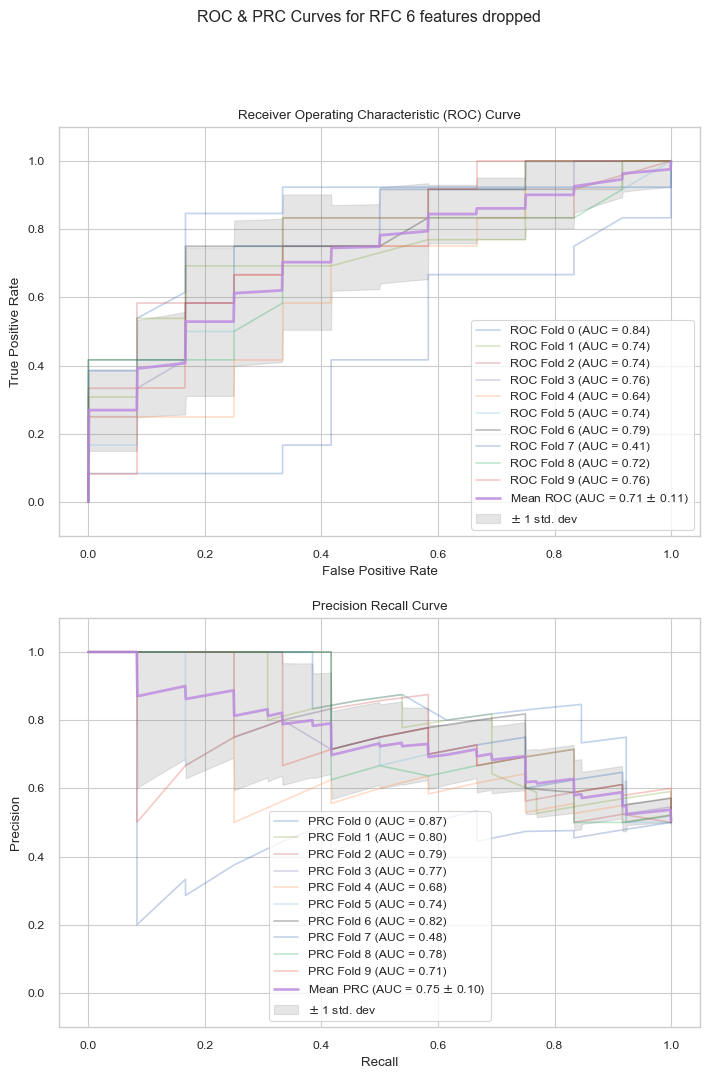

: 

In [203]:
for result in zip(results, ["0 features dropped", "1 feature dropped", "2 features dropped", "4 features dropped", "6 features dropped"]):
    k_fold_roc_curve(result[0], f"RFC {result[1]}")

## AdaBoost

--- Fold 0 ---
0.8
--- Fold 1 ---
0.68
--- Fold 2 ---
0.7916666666666666
--- Fold 3 ---
0.8333333333333334
--- Fold 4 ---
0.75
--- Fold 5 ---
0.7916666666666666
--- Fold 6 ---
0.75
--- Fold 7 ---
0.5833333333333334
--- Fold 8 ---
0.6666666666666666
--- Fold 9 ---
0.75


100%|██████████| 10/10 [00:00<00:00, 769.33it/s]


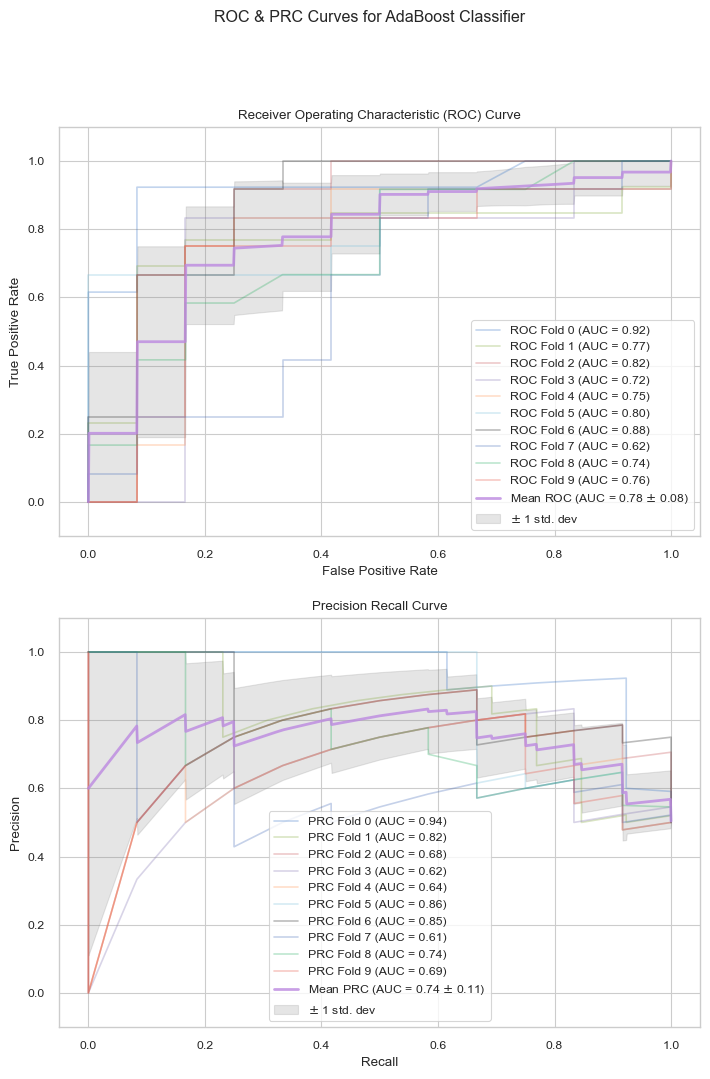

In [102]:
adb = AdaBoostClassifier(n_estimators=100, random_state=42)
adb_10f_outputs = ten_fold_cross_validation(skf, adb, X, Y)
k_fold_roc_curve(adb_10f_outputs, "AdaBoost Classifier")

### Hyperparam Tuning

In [103]:
adb = AdaBoostClassifier(random_state=42)
dist = {
    "n_estimators": [1, 2, 4, 8, 16, 32, 50, 64, 100, 128, 256, 512, 1024],
    "learning_rate": [3e-3, 1e-3, 3e-2, 1e-2, 3e-1, 1e-1, 3e-1, 1.0],
    "algorithm": ["SAMME", "SAMME.R"],
}
adb_rs = RandomizedSearchCV(adb, dist, random_state=42, n_iter=60, scoring="roc_auc", verbose=1, error_score="raise")
# with parallel_backend("threading", n_jobs=12):
search = adb_rs.fit(X.to_numpy(), Y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [104]:
adb_rs.best_params_

{'n_estimators': 512, 'learning_rate': 0.03, 'algorithm': 'SAMME.R'}

--- Fold 0 ---
0.68
--- Fold 1 ---
0.8
--- Fold 2 ---
0.7916666666666666
--- Fold 3 ---
0.875
--- Fold 4 ---
0.5416666666666666
--- Fold 5 ---
0.8333333333333334
--- Fold 6 ---
0.75
--- Fold 7 ---
0.5
--- Fold 8 ---
0.7083333333333334
--- Fold 9 ---
0.8333333333333334


100%|██████████| 10/10 [00:00<00:00, 833.34it/s]


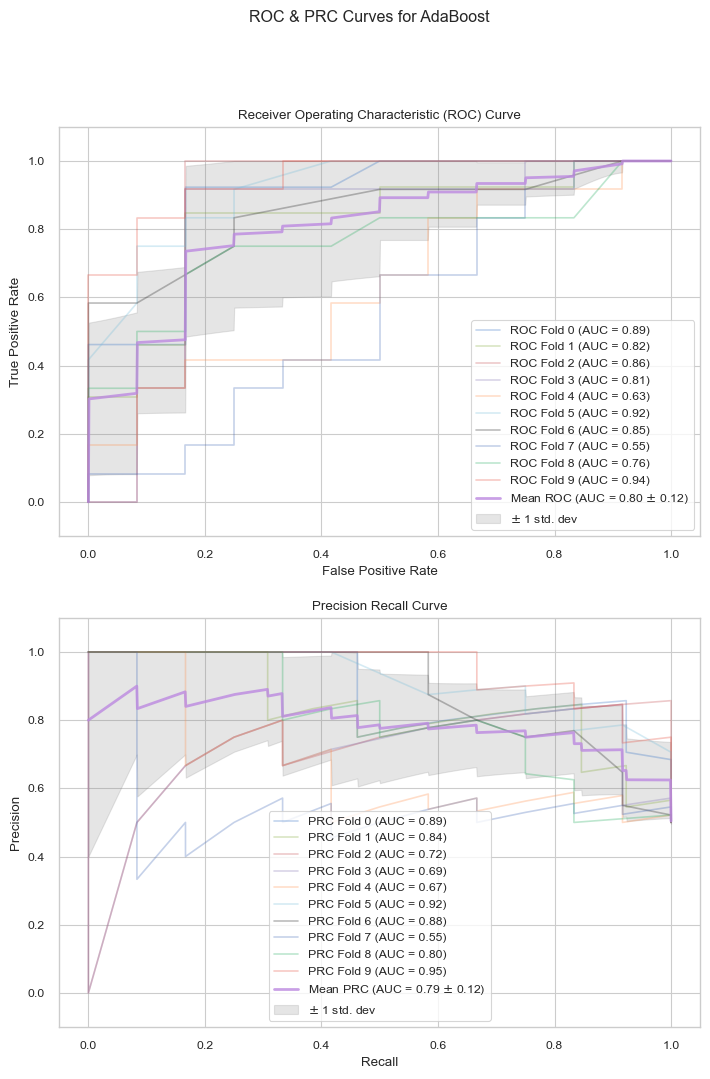

In [105]:
adb_rs_10f_outputs = ten_fold_cross_validation(skf, adb_rs.best_estimator_, X, Y)
k_fold_roc_curve(adb_rs_10f_outputs, "AdaBoost")

## XGBoost

--- Fold 0 ---
0.84
--- Fold 1 ---
0.68
--- Fold 2 ---
0.8333333333333334
--- Fold 3 ---
0.875
--- Fold 4 ---
0.7083333333333334
--- Fold 5 ---
0.875
--- Fold 6 ---
0.7916666666666666
--- Fold 7 ---
0.7083333333333334
--- Fold 8 ---
0.7083333333333334
--- Fold 9 ---
0.8333333333333334


100%|██████████| 10/10 [00:00<00:00, 526.35it/s]


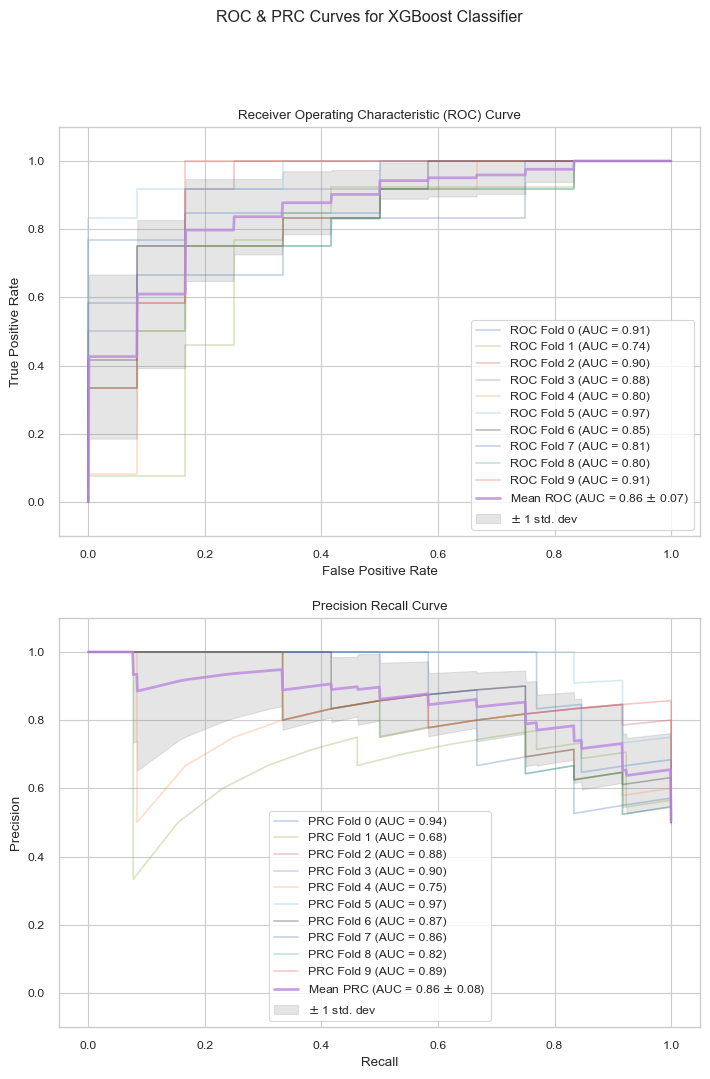

In [106]:
xgb = XGBClassifier(tree_method='auto', objective="binary:logistic")
xgb_10f_outputs = ten_fold_cross_validation(skf, xgb, X, Y)
k_fold_roc_curve(xgb_10f_outputs, "XGBoost Classifier")

In [144]:
(Y == 0).sum() / (Y == 1).sum()

0.9836065573770492

### Hyperparam Tuning

In [107]:
xgb = XGBClassifier(nthread=12, process_type="default", sampling_method="uniform")
dist = {
    "eta": [3e-2, 1e-1, 3e-1, 1.0],
    "gamma": [0, 0.3, 1.0, 3.0],
    "max_depth": [1, 2, 4, 8, 16],
    "min_child_weight": [0.1, 0.3, 1.0, 3.0, 10.0],
    "subsample": [0.1, 0.2, 0.5, 0.75, 1.0],
    "colsample_bytree": [0.1, 0.25, 0.5, 0.75, 1.0],
    "colsample_bylevel": [0.1, 0.25, 0.5, 0.75, 1.0],
    "colsample_bynode": [0.1, 0.25, 0.5, 0.75, 1.0],
    "lambda": [0.0, 0.25, 0.5, 0.75, 1.0],
    "alpha": [0.0, 0.25, 0.5, 0.75, 1.0],
    "tree_method": ["auto", "exact", "approx", "hist"],
    "scale_pos_weight": [1.0, 0.9836065573770492],
    "refresh_leaf": [0, 1],
    "max_leaves": [0, 1, 2, 4, 8, 16, 32, 64],
}
np.prod([len(x) for x in dist.values()])

800000000

In [108]:
xgb_rs = RandomizedSearchCV(xgb, dist, random_state=42, n_iter=60, scoring="roc_auc", verbose=1, error_score="raise")
# with parallel_backend("threading", n_jobs=12):
search = xgb_rs.fit(X.to_numpy(), Y)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [109]:
xgb_rs.best_params_

{'tree_method': 'exact',
 'subsample': 0.75,
 'scale_pos_weight': 0.9836065573770492,
 'refresh_leaf': 1,
 'min_child_weight': 0.3,
 'max_leaves': 8,
 'max_depth': 16,
 'lambda': 0.0,
 'gamma': 0.3,
 'eta': 0.3,
 'colsample_bytree': 0.75,
 'colsample_bynode': 0.1,
 'colsample_bylevel': 0.5,
 'alpha': 0.0}

--- Fold 0 ---
0.8
--- Fold 1 ---
0.68
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.875
--- Fold 4 ---
0.7083333333333334
--- Fold 5 ---
0.875
--- Fold 6 ---
0.875
--- Fold 7 ---
0.6666666666666666
--- Fold 8 ---
0.6666666666666666
--- Fold 9 ---
0.875


100%|██████████| 10/10 [00:00<00:00, 588.19it/s]


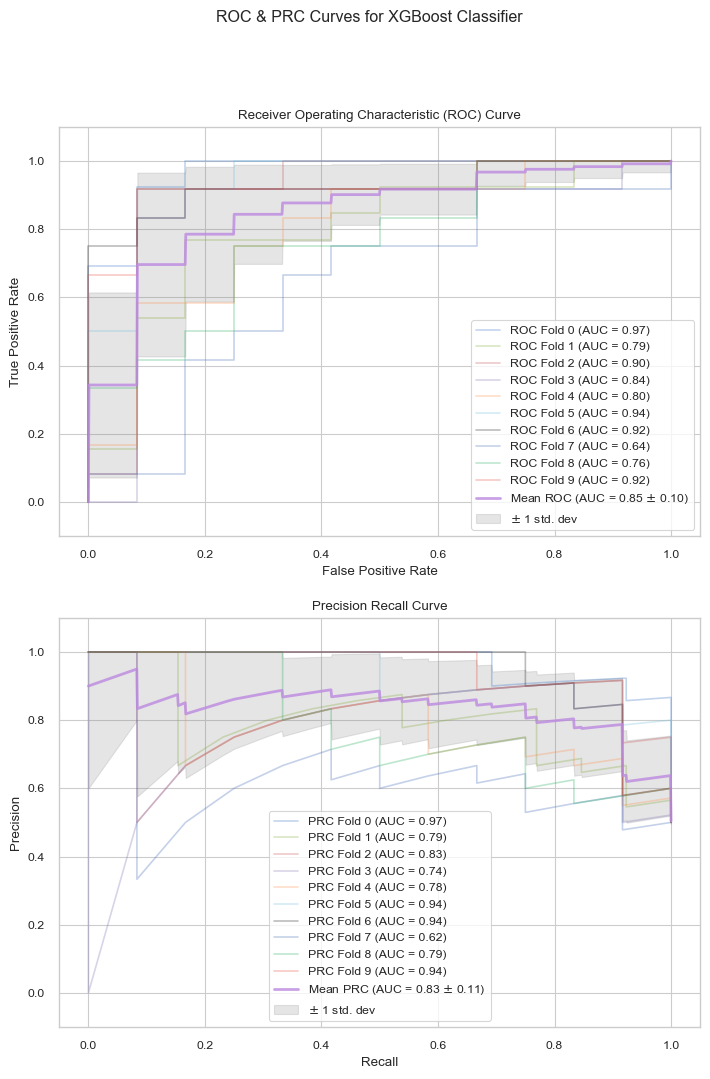

In [110]:
xgb_rs_10f_outputs = ten_fold_cross_validation(skf, xgb_rs.best_estimator_, X, Y)
k_fold_roc_curve(xgb_rs_10f_outputs, "XGBoost Classifier")

In [145]:
class XGBObjective(object):
    def __init__(self, X, Y, skf):
        self.X = X.to_numpy()
        self.Y = Y
        self.skf = skf
    
    def __call__(self, trial) -> float:
        eta = trial.suggest_float("eta", 3e-4, 1.0, log=True)
        gamma = trial.suggest_float("gamma", 1e-3, 4.0, log=True)
        max_depth = trial.suggest_int("max_depth", 1, 64, log=True)
        min_child_weight = trial.suggest_float("min_child_weight", 1e-2, 10.0, log=True)
        subsample = trial.suggest_float("subsample", 1e-3, 1.0, log=True)
        colsample_bytree = trial.suggest_float("colsample_bytree", 1e-2, 1.0, log=True)
        colsample_bylevel = trial.suggest_float("colsample_bylevel", 1e-2, 1.0, log=True)
        colsample_bynode = trial.suggest_float("colsample_bynode", 1e-2, 1.0, log=True)
        xgb_lambda = trial.suggest_float("lambda", 1e-5, 1.0, log=True)
        alpha = trial.suggest_float("alpha", 1e-5, 1.0, log=True)
        tree_method = trial.suggest_categorical("tree_method", ["auto", "exact", "approx", "hist"])
        scale_pos_weight = trial.suggest_categorical("scale_pos_weight", [1.0, 0.9836065573770492])
        refresh_leaf = trial.suggest_categorical("refresh_leaf", [0, 1])
        max_leaves = trial.suggest_int("max_leaves", 1, 256, log=True)
        clf = XGBClassifier(
            n_jobs=12,
            random_state=42,
            eta=eta,
            gamma=gamma,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            colsample_bynode=colsample_bynode,
            reg_lambda=xgb_lambda,
            reg_alpha=alpha,
            tree_method=tree_method,
            scale_pos_weight=scale_pos_weight,
            refresh_leaf=refresh_leaf,
            max_leaves=max_leaves
        )
        score = cross_val_score(clf, self.X, self.Y, n_jobs=12, cv=self.skf, scoring="roc_auc")
        return score.mean()

In [146]:
xgb_objective = XGBObjective(X, Y, skf)
study = optuna.create_study(direction="maximize")
study.optimize(xgb_objective, n_trials=150)
print(study.best_trial)

[I 2023-04-07 13:10:04,670] A new study created in memory with name: no-name-e8082d71-1dd4-48fb-bbad-4f19a380a76f
[I 2023-04-07 13:10:06,746] Trial 0 finished with value: 0.5 and parameters: {'eta': 0.0019023332550521612, 'gamma': 0.1278858156970273, 'max_depth': 5, 'min_child_weight': 0.2542054956105648, 'subsample': 0.0032512917201687245, 'colsample_bytree': 0.16540044198773957, 'colsample_bylevel': 0.7336193824927503, 'colsample_bynode': 0.01066626917059756, 'lambda': 0.0264279756767086, 'alpha': 0.35581384880573097, 'tree_method': 'exact', 'scale_pos_weight': 0.9836065573770492, 'refresh_leaf': 1, 'max_leaves': 1}. Best is trial 0 with value: 0.5.
[I 2023-04-07 13:10:07,715] Trial 1 finished with value: 0.5 and parameters: {'eta': 0.029018059435247604, 'gamma': 0.004373608392709902, 'max_depth': 1, 'min_child_weight': 3.5856473723114446, 'subsample': 0.013838973524940996, 'colsample_bytree': 0.9459258447419352, 'colsample_bylevel': 0.0215083004941484, 'colsample_bynode': 0.18732224

FrozenTrial(number=138, state=TrialState.COMPLETE, values=[0.8638888888888887], datetime_start=datetime.datetime(2023, 4, 7, 13, 10, 33, 422018), datetime_complete=datetime.datetime(2023, 4, 7, 13, 10, 33, 614018), params={'eta': 0.5071902872675725, 'gamma': 0.7028125860876465, 'max_depth': 51, 'min_child_weight': 0.20971348253481706, 'subsample': 0.7807336133469328, 'colsample_bytree': 0.14733697399324966, 'colsample_bylevel': 0.012063230215663646, 'colsample_bynode': 0.24676765907327394, 'lambda': 0.08540878613706193, 'alpha': 0.017997374310435667, 'tree_method': 'auto', 'scale_pos_weight': 1.0, 'refresh_leaf': 0, 'max_leaves': 36}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'eta': FloatDistribution(high=1.0, log=True, low=0.0003, step=None), 'gamma': FloatDistribution(high=4.0, log=True, low=0.001, step=None), 'max_depth': IntDistribution(high=64, log=True, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=True, low=0.01, step=None), 's

--- Fold 0 ---
0.72
--- Fold 1 ---
0.6
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.875
--- Fold 4 ---
0.7083333333333334
--- Fold 5 ---
0.7916666666666666
--- Fold 6 ---
0.75
--- Fold 7 ---
0.625
--- Fold 8 ---
0.7916666666666666
--- Fold 9 ---
0.8333333333333334


100%|██████████| 10/10 [00:00<00:00, 588.25it/s]


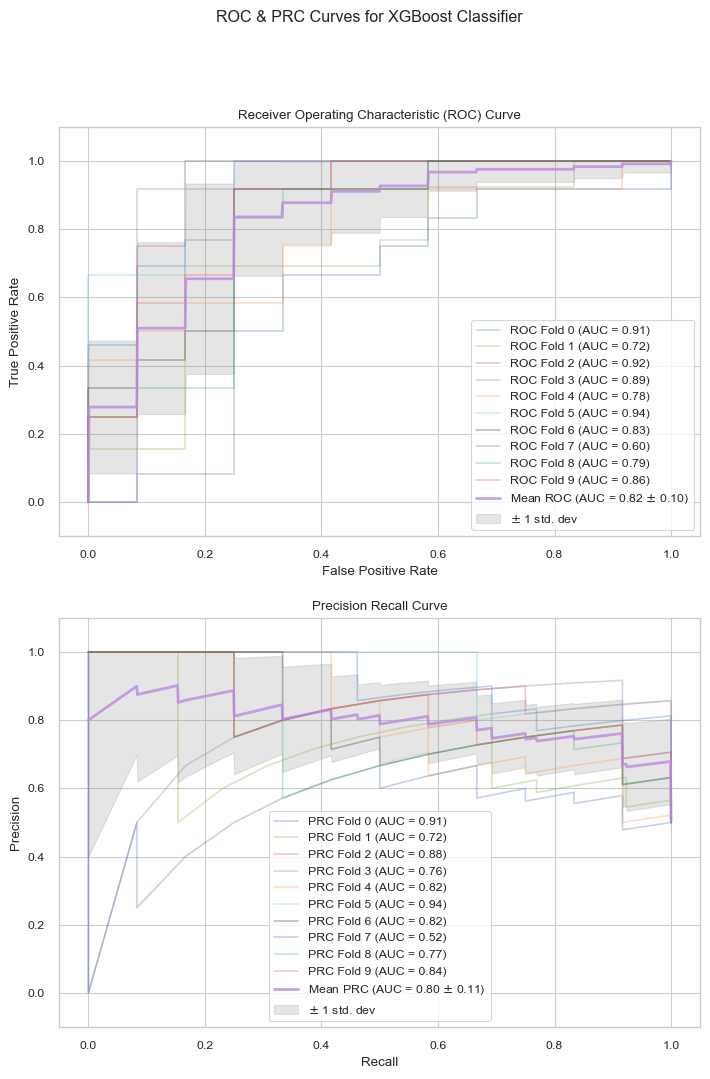

In [150]:
xgb_opt = XGBClassifier(
    eta=0.5071902872675725,
    gamma=0.7028125860876465,
    max_depth=51,
    min_child_weight=0.20971348253481706,
    subsample=0.7807336133469328,
    colsample_bytree=0.14733697399324966,
    colsample_bylevel=0.012063230215663646,
    colsample_bynode=0.24676765907327394,
    reg_lambda=0.08540878613706193,
    reg_alpha=0.017997374310435667,
    tree_method='auto',
    scale_pos_weight=1.0,
    refresh_leaf=0,
    max_leaves=36
)
xgb_opt_10f_outputs = ten_fold_cross_validation(skf, xgb_opt, X, Y)
k_fold_roc_curve(xgb_opt_10f_outputs, "XGBoost Classifier")

### Ablation Study

In [111]:
results = [xgb_rs_10f_outputs]
for clusters_drop in tqdm([("4"), ("4", "3"), ("4", "3", "2")]):
    cols = []
    for cluster in clusters_drop:
        cols += [f"cluster_{cluster}_span", f"cluster_{cluster}_min_amp", f"cluster_{cluster}_max_amp", f"cluster_{cluster}_height_amp", f"cluster_{cluster}_mean_amp", f"cluster_{cluster}_grad", f"cluster_{cluster}_std"]
    X_ablation = X.drop(cols)
    skf_ablation = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    skf_ablation.get_n_splits(X_ablation, Y)
    xgb_ablation = XGBClassifier(**xgb_rs.best_params_, n_jobs=12, random_state=42)
    skf_results = ten_fold_cross_validation(skf_ablation, xgb_ablation, X_ablation, Y)
    results.append(skf_results)

  0%|          | 0/3 [00:00<?, ?it/s]

--- Fold 0 ---
0.84
--- Fold 1 ---
0.68
--- Fold 2 ---
0.875
--- Fold 3 ---
0.8333333333333334
--- Fold 4 ---
0.6666666666666666
--- Fold 5 ---
0.9166666666666666
--- Fold 6 ---


 33%|███▎      | 1/3 [00:00<00:00,  3.11it/s]

0.7083333333333334
--- Fold 7 ---
0.5416666666666666
--- Fold 8 ---
0.7916666666666666
--- Fold 9 ---
0.7916666666666666
--- Fold 0 ---
0.84
--- Fold 1 ---
0.72
--- Fold 2 ---
0.9166666666666666
--- Fold 3 ---
0.8333333333333334
--- Fold 4 ---
0.625
--- Fold 5 ---
0.8333333333333334
--- Fold 6 ---
0.7916666666666666
--- Fold 7 ---
0.7083333333333334
--- Fold 8 ---


 67%|██████▋   | 2/3 [00:00<00:00,  2.79it/s]

0.75
--- Fold 9 ---
0.8333333333333334
--- Fold 0 ---
0.8
--- Fold 1 ---
0.72
--- Fold 2 ---
0.875
--- Fold 3 ---
0.875
--- Fold 4 ---
0.6666666666666666
--- Fold 5 ---
0.8333333333333334
--- Fold 6 ---
0.7083333333333334
--- Fold 7 ---
0.6666666666666666
--- Fold 8 ---
0.7916666666666666
--- Fold 9 ---
0.75


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


100%|██████████| 10/10 [00:00<00:00, 714.25it/s]


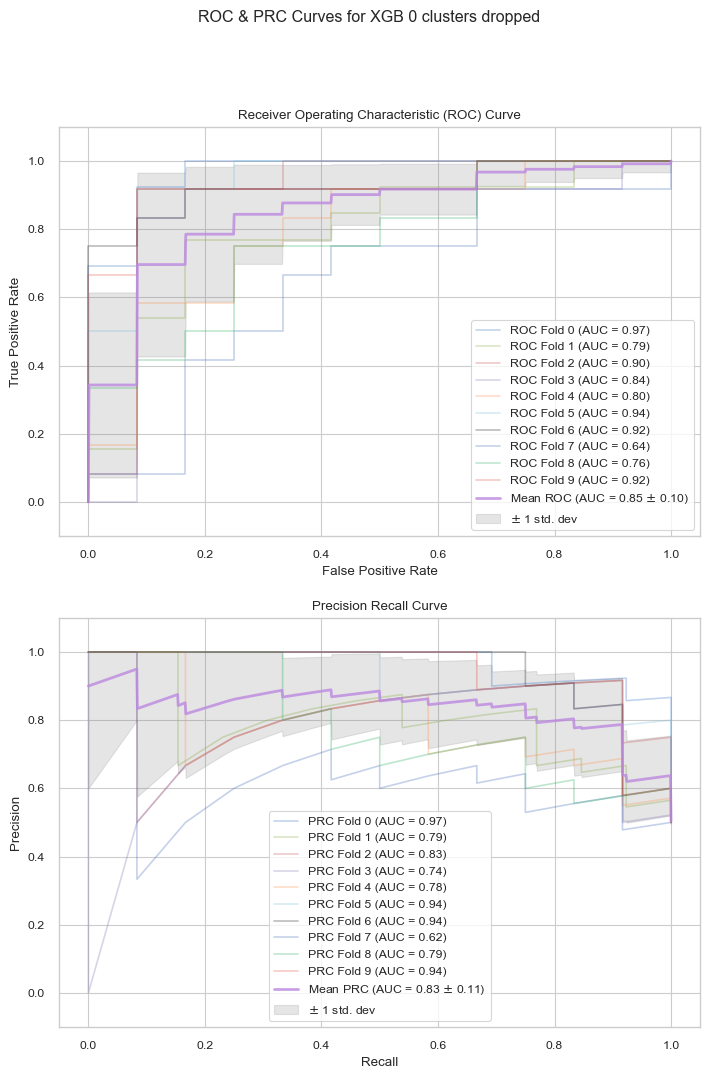

100%|██████████| 10/10 [00:00<00:00, 714.24it/s]


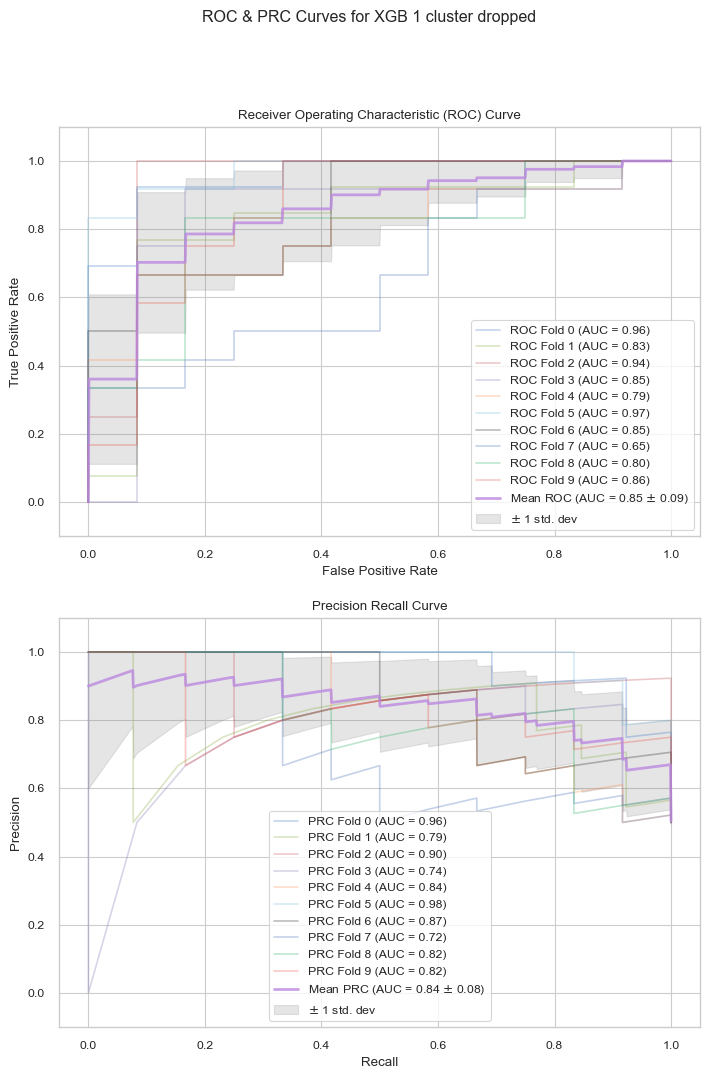

100%|██████████| 10/10 [00:00<00:00, 61.73it/s]


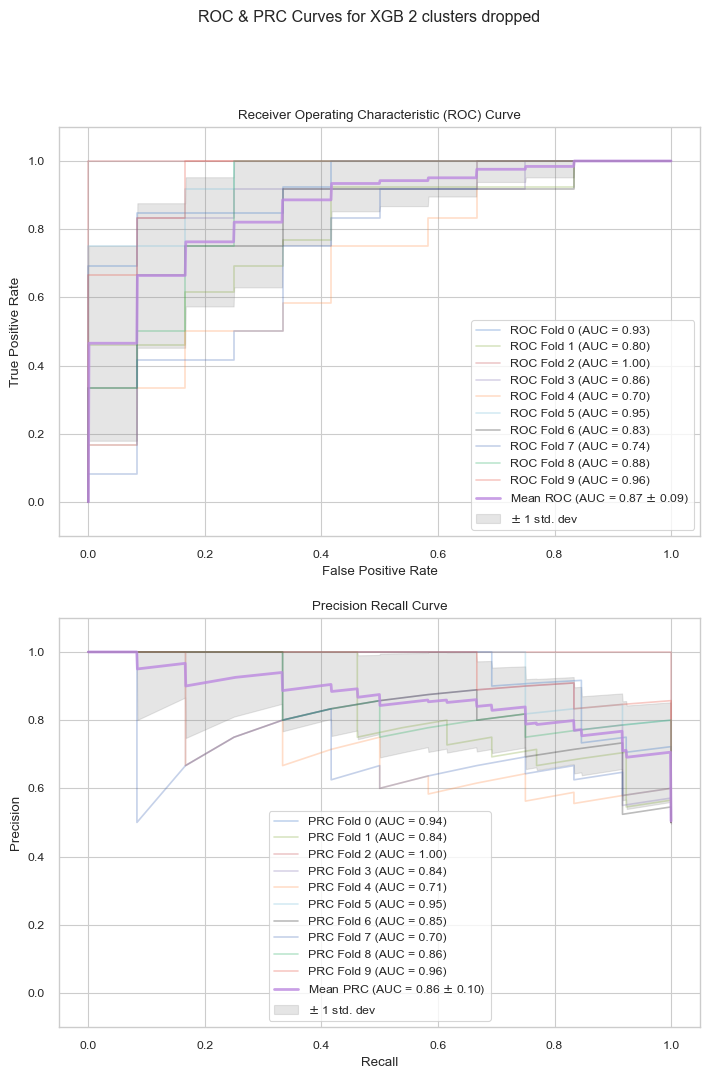

100%|██████████| 10/10 [00:00<00:00, 666.71it/s]


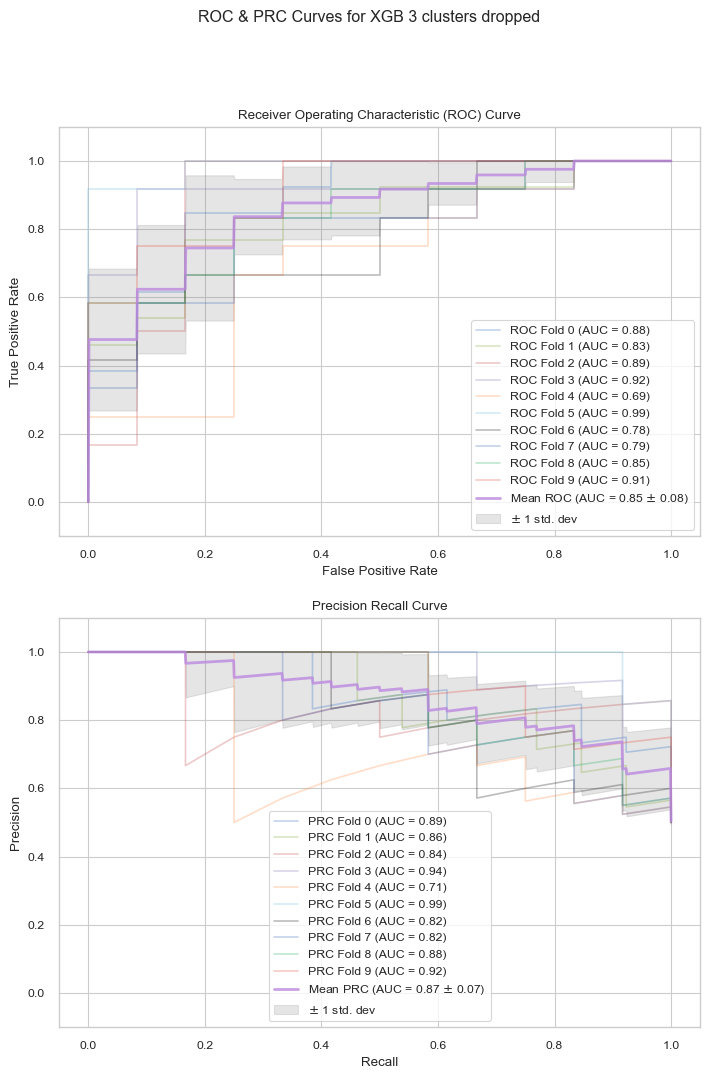

In [112]:
for result in zip(results, ["0 clusters dropped", "1 cluster dropped", "2 clusters dropped", "3 clusters dropped"]):
    k_fold_roc_curve(result[0], f"XGB {result[1]}")

### Confusion Matrix

In [87]:
xgb_10f_y = []
xgb_10f_preds = []
for output in xgb_rs_10f_outputs:
    xgb_10f_y.append(output["y"].to_numpy())
    xgb_10f_preds.append(output["preds"])
    
xgb_10f_y = np.concatenate(xgb_10f_y)
xgb_10f_preds = np.concatenate(xgb_10f_preds)

print(classification_report(xgb_10f_y, xgb_10f_preds))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       120
           1       0.74      0.79      0.76       122

    accuracy                           0.76       242
   macro avg       0.76      0.76      0.76       242
weighted avg       0.76      0.76      0.76       242

